In [1]:
import os
import mne
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mne_connectivity import spectral_connectivity_epochs, seed_target_indices

from resting_state.settings import *
from shared.helper_functions import save_figure, select_folder, select_or_create_folder
from settings_general import low_qual_chans, freq_bands_eeg

Change plot theme

In [18]:
sns.set_theme()

And define a palette to plot with

In [109]:
palette = {'DRD2-WT': '#49A078', 'DRD2-KO': '#ED7D3A'}
cmap_palette = 'YlOrBr'

Let the user select the needed folders

In [2]:
epoch_folder = select_folder("Select the folder that holds epoch files starting with 'epochs_w_cluster_annotations'")
plot_folder = select_or_create_folder("Create or select a folder the plots will be saved to")

List with channels we're not interested in

In [4]:
excluded_chans = ['EMG_L', 'EMG_R']

## Let's load all needed epochs

In [7]:
all_subject_epochs = []
for file in os.listdir(epoch_folder):
    subj_id = file.split('_')[-1].split('-')[0]
    if not file.startswith('epochs_w_cluster_annotations') or int(subj_id) in omitted_after_clustering or int(
            subj_id) in omitted_other:
        continue
    all_subject_epochs.append(mne.read_epochs(os.path.join(epoch_folder, file), preload=True, verbose='WARNING'))

## Regular connectivity analysis

Let's first define a function that allows us to compute the connectivity using a provided method/metric

In [71]:
def compute_con(epochs, method, fmin=0, fmax=100):
    # Compute spectral connectivity
    con = spectral_connectivity_epochs(
        epochs, method=method, mode='multitaper', sfreq=epochs.info['sfreq'],
        fmin=fmin, fmax=fmax, faverage=True, verbose='WARNING', gc_n_lags=40)
    return con.get_data(output='dense')

And a function that computes a dataframe holding the connectivity for all the subject's epochs.

In [86]:
def connectivity_df(subject_epoch_objects, subject_ids, method):
    print(f'Computing {method} connectivity for subjects:\n {subject_ids}')
    results_df = pd.DataFrame()

    # per subject, calculate the given measure for all epochs
    for subject_epochs in subject_epoch_objects:
        subject_id = int(subject_epochs.metadata['animal_id'].iloc[0])
        if subject_id not in subject_ids or subject_id in omitted_after_clustering or subject_id in omitted_other:
            print(f'Not computing connectivity measure for subject {subject_id} because of quality')
            continue
            
        genotype = subject_epochs.metadata['genotype'].iloc[0]
        
        # get only resting-state epochs
        annotations = cluster_annotations[int(subject_id)]
        resting_epochs = subject_epochs[subject_epochs.metadata["cluster"] == annotations['rest']]
        resting_epochs = resting_epochs.drop_channels(excluded_chans)
    
        # compute the given connectivity measure for every frequency band
        for band_name, (fmin, fmax) in freq_bands_eeg.items():
            # compute the connectivity using the provided method
            con = compute_con(resting_epochs, method, fmin, fmax)
            
            # loop through every channel combination
            for i in range(con.shape[1]):
                for j in range(i+1, con.shape[0]):
                    if subject_id in low_qual_chans.keys():
                        if resting_epochs.ch_names[i] in low_qual_chans[subject_id] or resting_epochs.ch_names[j] in low_qual_chans[subject_id]:
                            continue
                    # add the data
                    results_df = pd.concat([results_df, pd.DataFrame({
                        'con' : con[j, i, 0],
                        'node1' : resting_epochs.ch_names[i],
                        'node2' : resting_epochs.ch_names[j],
                        'band' : band_name,
                        'subject_id': subject_id,
                        'genotype': genotype,
                        'method': method
                    }, index=[0])], ignore_index=True)
    print(f'Done computing {method} connectivity.')
    return results_df

And also a function that allows us to generate a heatmap of the connectivity per channel combination

In [96]:
def generate_con_heatmap(df, freq_band, cmap, fig_title='', method='', ax=None):
    # subset the data for a given frequency band
    filtered_df = df[df['band'] == freq_band]

    # generate pivot table with mean 'method' values
    pivot_table = filtered_df.pivot_table(index='node1', columns='node2', values='con', aggfunc='mean')

    # make table symmetric by filling missing values
    pivot_table = pivot_table.combine_first(pivot_table.T)

    # set diagonal and upper triangle values to NaN, this way we still plot all data
    for i in range(pivot_table.shape[0]):
        for j in range(i, pivot_table.shape[1]):
            pivot_table.iat[i, j] = np.nan

    fig = sns.heatmap(pivot_table, cmap=cmap, annot=True, fmt=".2f", vmin=0, vmax=1, ax=ax, square=True, cbar_kws={'shrink': 0.75})
    fig.set_title(fig_title)

    cbar = fig.collections[0].colorbar
    cbar.set_label(f'Mean {method}', fontsize=12)
    cbar.outline.set_edgecolor('black')
    cbar.outline.set_linewidth(1)

And a function that allows us to plot the connectivity differences between the two genotypes for the 4 channels of interest

In [97]:
def generate_grid_plot_wt_vs_ko(data):
    fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(24, 10))
    method = data['method'].iloc[0]
    freq_band_names = freq_bands_eeg.keys()
    genotypes = data['genotype'].unique()
    
    # loop through genotypes
    for i, genotype in enumerate(genotypes):
        genotype_data = data[data['genotype'] == genotype]
        for j, band in enumerate(freq_band_names):
            generate_con_heatmap(genotype_data, band, cmap=cmap_palette, fig_title=f'{genotype} - {band} Band', method=method, ax=ax[i, j])
    
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.25, hspace=-0.1)
    save_figure(os.path.join(plot_folder, f"connectivity/{method.upper()}_heatmap.pdf"))

Lastly a function that allows us to generate barplots of the connectivity measures

In [105]:
def generate_barplots(data):
    combinations = data['node1'] + '-' + data['node2']
    unique_combinations = combinations.unique()
    
    fig, axs = plt.subplots(nrows=3, ncols=7, figsize=(35, 15), sharey=True, sharex=True)
    axs = axs.ravel()
    
    method = data['method'].iloc[0]
    
    for i, combination in enumerate(unique_combinations):
        # subset the data
        chan1, chan2 = combination.split('-')
        data_subset = data[(data['node1'] == chan1) & (data['node2'] == chan2)]
        
        sns.barplot(data=data_subset, x="band", y="con", hue="genotype", palette=palette, hue_order=["DRD2-WT", "DRD2-KO"], ax=axs[i], errorbar=None)
        sns.stripplot(data=data_subset, x="band", y="con", hue="genotype", palette='dark:black', hue_order=["DRD2-WT", "DRD2-KO"], alpha=0.4, dodge=True, legend=False, ax=axs[i])
        
        axs[i].set_title(f"Connectivity of {chan1} and {chan2} ({method.upper()})")
        axs[i].set_xlabel("Frequency band")
        axs[i].set_ylabel(f"Connectivity ({method.upper()})")
    
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    plt.tight_layout()
    save_figure(os.path.join(plot_folder, f"connectivity/{method.upper()}_bar_grid.pdf"))

### Testing on a single subject (30958)

#### Phase Lag Index exploration

In [21]:
for obj in all_subject_epochs:
    if obj.metadata.animal_id.iloc[0] == '39508':
        epochs_39508 = obj.copy()
        
epochs_39508.drop_channels(['S1_L', 'S1_R', 'V1_R', 'EMG_L', 'EMG_R'])
epochs_39508.info['ch_names']

['OFC_R', 'OFC_L', 'CG', 'STR_R']

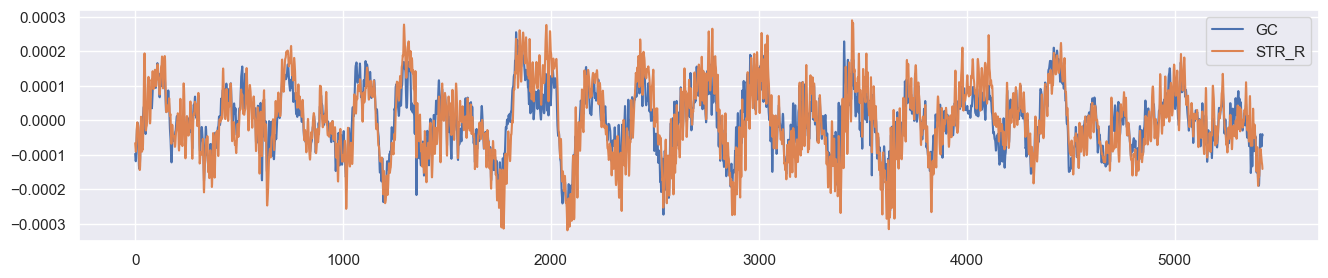

In [30]:
fig = plt.figure(figsize=(16, 3))
plt.plot(epochs_39508[100].get_data(picks='CG')[0,0,:], label='GC')
plt.plot(epochs_39508[100].get_data(picks='STR_R')[0,0,:], label='STR_R')
plt.legend()

Visually, it doesn't seem like one signal is leading or lagging the other.

In [31]:
seeds = [idx for idx, ch_info in enumerate(['OFC_R', 'OFC_L', 'CG', 'STR_R'])]
targets = [idx for idx, ch_info in enumerate(['OFC_R', 'OFC_L', 'CG', 'STR_R'])]
indices = seed_target_indices(seeds, targets)
print(f'Bi-variate indexes used for pairwise connectivity calculations:\n {indices}')

# calculate dpli for one specific epoch
dpli_test = spectral_connectivity_epochs(
    epochs_39508[100], indices=indices, sfreq=epochs_39508.info['sfreq'], method="dpli", fmin=0, fmax=100
)

# report some stuff
print(f'\nShape of the dpli output: {dpli_test.get_data(output="dense").shape}')
print(f'\nLength of the frequency array (holds at which the dPLI is calculated): {len(dpli_test.freqs)}')
print(f'\nThe dPLI output:\n {dpli_test.get_data(output="dense")}')

Bi-variate indexes used for pairwise connectivity calculations:
 (array([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3]), array([0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3]))
Connectivity computation...
    computing connectivity for 16 connections
    using t=0.000s..4.999s for estimation (5423 points)
    frequencies: 0.0Hz..99.8Hz (500 points)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: DPLI
    computing cross-spectral density for epoch 1
[Connectivity computation done]

Shape of the dpli output: (4, 4, 500)

Length of the frequency array (holds at which the dPLI is calculated): 500

The dPLI output:
 [[[0.5 1.  0.  ... 1.  1.  0. ]
  [0.5 1.  1.  ... 0.  0.  0. ]
  [0.5 1.  1.  ... 0.  0.  0. ]
  [0.5 0.  1.  ... 0.  0.  0. ]]

 [[0.5 0.  0.  ... 1.  1.  1. ]
  [0.5 0.  1.  ... 0.  1.  0. ]
  [0.5 0.  0.  ... 1.  1.  1. ]
  [0.5 0.  0.  ... 1.  1.  1. ]]

 [[0.5 0.  0.  ... 1.  1.  1. ]
  [0.5 1.  1.  ... 0.  0.  0.

C:\Users\Olle de Jong\Documents\MSc Biology\rp2\social-experiments\venv\Lib\site-packages\mne_connectivity\spectral\epochs.py:186: RuntimeWarning: divide by zero encountered in scalar divide
  5.0 / np.min(fmin),
C:\Users\Olle de Jong\AppData\Local\Temp\ipykernel_1972\3843220468.py:7: RuntimeWarning: fmin=0.000 Hz corresponds to 0.000 < 5 cycles based on the epoch length 4.999 sec, need at least inf sec epochs or fmin=1.000. Spectrum estimate will be unreliable.
  dpli_test = spectral_connectivity_epochs(


Above, we calculated the dpli connectivity measure for one specific epoch. Because we put 'OFC_R', 'OFC_L', 'CG', 'STR_R' in as indices, we get 4x4 = 16 dPLI values per chan to chan comparison. However, we receive a dPLI value per frequency, here resulting in 495 values, which describe the connectivity a different frequencies (see len(dpli_test.freqs))

As we compared the GC and STR_R channels of epoch at index 100 of the resting epochs of 39508, we grab the dPLI values for that specific comparison. Note: this is both from CG to STR_R, but also the other way around. Then we average the dPLI for both.

In [33]:
print(f'Mean dPLI for CG --> STR_R:  {np.average(dpli_test.get_data(output="dense")[2,3,:])}')
print(f'Mean dPLI for STR_R --> CG:  {np.average(dpli_test.get_data(output="dense")[3,2,:])}')

Mean dPLI for CG --> STR_R:  0.681
Mean dPLI for STR_R --> CG:  0.319


We can, from these, observe that they are each others opposites, which makes sense, as we calculate the **directed** phase-lag index here. If one leads or lags the other, the score of the reverse is gonna be the opposite. Note; the dPLI ranges from 0 to 1.

Now, how do we interpret this?

The reference (first provided signal) is lagging the other signal if dPLI is between 0 and 0.5, and the reference signal is leading the other signal is the dPLI is between 0.5 and 1.0.

So, the CG is leading the STR_R signal, or, the STR_R is lagging the CG signal.


#### Granger Causality exploration

In [53]:
# parietal sensors
signals_a = [
    idx
    for idx, ch_info in enumerate(epochs_39508.info["chs"])
    if ch_info["ch_name"] == "STR_R" # TODO can add condition for channel here
]
# occipital sensors
signals_b = [
    idx
    for idx, ch_info in enumerate(epochs_39508.info["chs"])
    if ch_info["ch_name"] == "CG"
]

indices_ab = (np.array([signals_a]), np.array([signals_b]))  # A => B
indices_ba = (np.array([signals_b]), np.array([signals_a]))  # B => A
print(indices_ab)
print(indices_ba)

(array([[3]]), array([[2]]))
(array([[2]]), array([[3]]))


In [54]:
gc_ab = spectral_connectivity_epochs(
    epochs_39508[100],
    method=["gc"],
    indices=indices_ab,
    fmin=5,
    fmax=30,
    gc_n_lags=20,
    verbose='WARNING'
)  # A => B
gc_ba = spectral_connectivity_epochs(
    epochs_39508[100],
    method=["gc"],
    indices=indices_ba,
    fmin=5,
    fmax=30,
    gc_n_lags=20,
    verbose='WARNING'
)  # B => A
freqs = gc_ab.freqs
print(gc_ab.shape)
print(gc_ab)

(1, 125)
<SpectralConnectivity | freq : [5.000549, 29.803273], , nave : 1, nodes, n_estimated : 4, 1, ~177 kB>


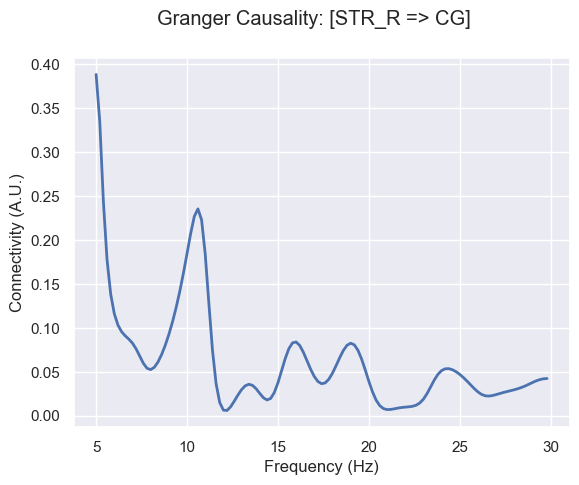

In [55]:
fig, axis = plt.subplots(1, 1)
axis.plot(freqs, gc_ab.get_data()[0], linewidth=2)
axis.set_xlabel("Frequency (Hz)")
axis.set_ylabel("Connectivity (A.U.)")
fig.suptitle("Granger Causality: [STR_R => CG]")
plt.show()

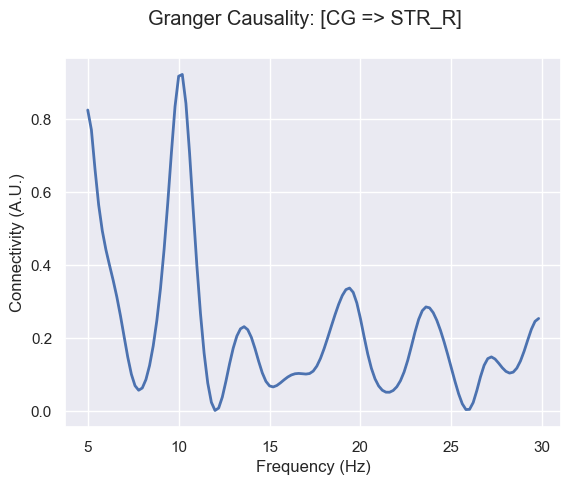

In [56]:
fig, axis = plt.subplots(1, 1)
axis.plot(freqs, gc_ba.get_data()[0], linewidth=2)
axis.set_xlabel("Frequency (Hz)")
axis.set_ylabel("Connectivity (A.U.)")
fig.suptitle("Granger Causality: [CG => STR_R]")
plt.show()

Text(0.5, 0.98, 'Net Granger Causality: [STR_R => CG] - [CG => STR_R]')

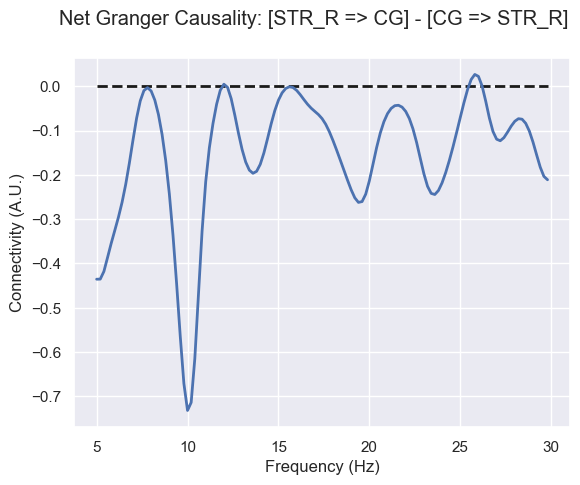

In [57]:
net_gc = gc_ab.get_data() - gc_ba.get_data()  # [A => B] - [B => A]

fig, axis = plt.subplots(1, 1)
axis.plot((freqs[0], freqs[-1]), (0, 0), linewidth=2, linestyle="--", color="k")
axis.plot(freqs, net_gc[0], linewidth=2)
axis.set_xlabel("Frequency (Hz)")
axis.set_ylabel("Connectivity (A.U.)")
fig.suptitle("Net Granger Causality: [STR_R => CG] - [CG => STR_R]")

By subtracting the flow of information from CG to STR_R from the flow of information of the reverse we get the net granger causality.

This tells us, that for this specific epoch, there's more information flow from the Cingulate Cortex to the Right Striatum than the other way around.

#### Time-traversed Granger Causality

In [58]:
# compute GC on time-reversed signals
gc_tr_ab = spectral_connectivity_epochs(
    epochs_39508[100],
    method=["gc_tr"],
    indices=indices_ab,
    fmin=5,
    fmax=30,
    gc_n_lags=20,
    verbose='WARNING'
)  # TR[A => B]
gc_tr_ba = spectral_connectivity_epochs(
    epochs_39508[100],
    method=["gc_tr"],
    indices=indices_ba,
    fmin=5,
    fmax=30,
    gc_n_lags=20,
    verbose='WARNING'
)  # TR[B => A]

# compute net GC on time-reversed signals (TR[A => B] - TR[B => A])
net_gc_tr = gc_tr_ab.get_data() - gc_tr_ba.get_data()

# compute TRGC
trgc = net_gc - net_gc_tr

Plot the net time-traversed GC

Text(0.5, 0.98, 'TRGC: net[STR_R => CG] - net time-reversed[CG => STR_R]')

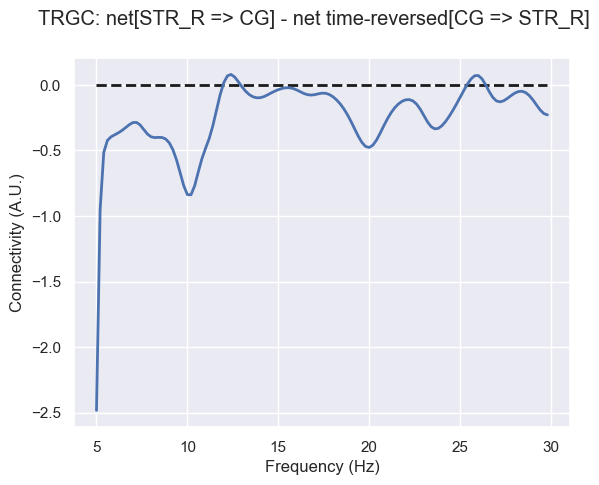

In [59]:
fig, axis = plt.subplots(1, 1)
axis.plot((freqs[0], freqs[-1]), (0, 0), linewidth=2, linestyle="--", color="k")
axis.plot(freqs, trgc[0], linewidth=2)
axis.set_xlabel("Frequency (Hz)")
axis.set_ylabel("Connectivity (A.U.)")
fig.suptitle("TRGC: net[STR_R => CG] - net time-reversed[CG => STR_R]")

Let's compute the net time-reversed granger causality for the frequencies 0 through 100 Hz.

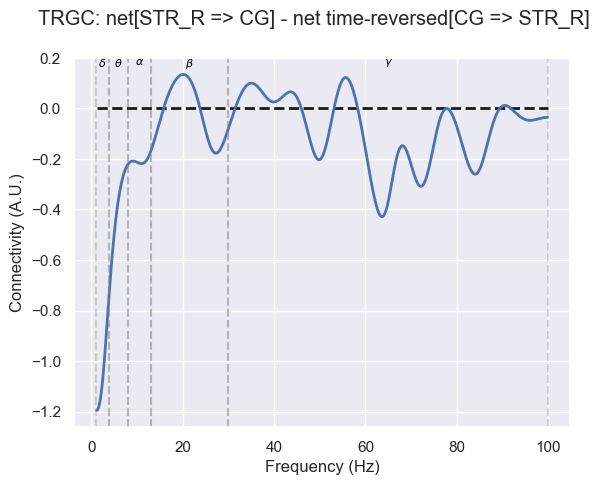

In [60]:
gc_ab = spectral_connectivity_epochs(
    epochs_39508[100],
    method=["gc"],
    indices=indices_ab,
    fmin=1.01,
    fmax=100,
    gc_n_lags=20,
    verbose='WARNING'
)  # A => B
gc_ba = spectral_connectivity_epochs(
    epochs_39508[100],
    method=["gc"],
    indices=indices_ba,
    fmin=1.01,
    fmax=100,
    gc_n_lags=20,
    verbose='WARNING'
)  # B => A
freqs = gc_ab.freqs
net_gc = gc_ab.get_data() - gc_ba.get_data()  # [A => B] - [B => A]
# compute GC on time-reversed signals
gc_tr_ab = spectral_connectivity_epochs(
    epochs_39508[100],
    method=["gc_tr"],
    indices=indices_ab,
    fmin=1.01,
    fmax=100,
    gc_n_lags=20,
    verbose='WARNING'
)  # TR[A => B]
gc_tr_ba = spectral_connectivity_epochs(
    epochs_39508[100],
    method=["gc_tr"],
    indices=indices_ba,
    fmin=1.01,
    fmax=100,
    gc_n_lags=20,
    verbose='WARNING'
)  # TR[B => A]

# compute net GC on time-reversed signals (TR[A => B] - TR[B => A])
net_gc_tr = gc_tr_ab.get_data() - gc_tr_ba.get_data()

# compute TRGC
trgc = net_gc - net_gc_tr

fig, axis = plt.subplots(1, 1)
axis.plot((freqs[0], freqs[-1]), (0, 0), linewidth=2, linestyle="--", color="k")
axis.plot(freqs, trgc[0], linewidth=2)
for band, (start, end) in freq_bands_eeg.items():
    axis.axvline(x=start, color='gray', linestyle='--', alpha=0.3)
    axis.axvline(x=end, color='gray', linestyle='--', alpha=0.3)
    axis.text((start + end) / 2, axis.get_ylim()[1] * 1.01, band, horizontalalignment='center', verticalalignment='top', fontsize=8, color='black')

axis.set_xlabel("Frequency (Hz)")
axis.set_ylabel("Connectivity (A.U.)")
fig.suptitle(f"TRGC: net[STR_R => CG] - net time-reversed[CG => STR_R]")
plt.show()

### Resting-state, DRD2-KO vs DRD2-WT

As mentioned in the 'rest_psd_analysis.ipynb' notebook, there are a few animals of which the quality is quite poor. We omitted them from the power analysis, so we will do the same here.

In [63]:
wt_ids = [sub_obj.metadata["animal_id"].iloc[0] for sub_obj in all_subject_epochs if sub_obj.metadata["genotype"].iloc[0] == "DRD2-WT"]
ko_ids = [sub_obj.metadata["animal_id"].iloc[0] for sub_obj in all_subject_epochs if sub_obj.metadata["genotype"].iloc[0] == "DRD2-KO"]
print(wt_ids)
print(ko_ids)

['39508', '79602', '80620', '80630', '81207', '81217']
['39489', '78211', '78227', '79592', '79593', '79604', '80625', '81175', '81193', '81218']


We thus remove 81217, 79604, 81193, and 39489.

In [66]:
[wt_ids.remove(x) for x in ['81217', '79604', '81193', '39489'] if x in wt_ids]
[ko_ids.remove(x) for x in ['81217', '79604', '81193', '39489'] if x in ko_ids]
print(wt_ids)
print(ko_ids)

['39508', '79602', '80620', '80630', '81207']
['78211', '78227', '79592', '79593', '80625', '81175', '81218']


In [70]:
passed_subject_ids = wt_ids + ko_ids
passed_subject_ids = [int(x) for x in passed_subject_ids]
passed_subject_ids

[39508,
 79602,
 80620,
 80630,
 81207,
 78211,
 78227,
 79592,
 79593,
 80625,
 81175,
 81218]

### Coherence (coh)

In [89]:
coh = connectivity_df(all_subject_epochs, passed_subject_ids, "coh")
coh.head()

Computing coh connectivity for subjects:
 [39508, 79602, 80620, 80630, 81207, 78211, 78227, 79592, 79593, 80625, 81175, 81218]
Not computing connectivity measure for subject 39489 because of quality


C:\Users\Olle de Jong\AppData\Local\Temp\ipykernel_1972\398803393.py:3: RuntimeWarning: fmin=1.000 Hz corresponds to 4.999 < 5 cycles based on the epoch length 4.999 sec, need at least 5.000 sec epochs or fmin=1.000. Spectrum estimate will be unreliable.
  con = spectral_connectivity_epochs(
C:\Users\Olle de Jong\AppData\Local\Temp\ipykernel_1972\398803393.py:3: RuntimeWarning: fmin=1.000 Hz corresponds to 4.999 < 5 cycles based on the epoch length 4.999 sec, need at least 5.000 sec epochs or fmin=1.000. Spectrum estimate will be unreliable.
  con = spectral_connectivity_epochs(
C:\Users\Olle de Jong\AppData\Local\Temp\ipykernel_1972\398803393.py:3: RuntimeWarning: fmin=1.000 Hz corresponds to 4.999 < 5 cycles based on the epoch length 4.999 sec, need at least 5.000 sec epochs or fmin=1.000. Spectrum estimate will be unreliable.
  con = spectral_connectivity_epochs(
C:\Users\Olle de Jong\AppData\Local\Temp\ipykernel_1972\398803393.py:3: RuntimeWarning: fmin=1.000 Hz corresponds to 4.99

Not computing connectivity measure for subject 79604 because of quality


C:\Users\Olle de Jong\AppData\Local\Temp\ipykernel_1972\398803393.py:3: RuntimeWarning: fmin=1.000 Hz corresponds to 4.999 < 5 cycles based on the epoch length 4.999 sec, need at least 5.000 sec epochs or fmin=1.000. Spectrum estimate will be unreliable.
  con = spectral_connectivity_epochs(
C:\Users\Olle de Jong\AppData\Local\Temp\ipykernel_1972\398803393.py:3: RuntimeWarning: fmin=1.000 Hz corresponds to 4.999 < 5 cycles based on the epoch length 4.999 sec, need at least 5.000 sec epochs or fmin=1.000. Spectrum estimate will be unreliable.
  con = spectral_connectivity_epochs(
C:\Users\Olle de Jong\AppData\Local\Temp\ipykernel_1972\398803393.py:3: RuntimeWarning: fmin=1.000 Hz corresponds to 4.999 < 5 cycles based on the epoch length 4.999 sec, need at least 5.000 sec epochs or fmin=1.000. Spectrum estimate will be unreliable.
  con = spectral_connectivity_epochs(
C:\Users\Olle de Jong\AppData\Local\Temp\ipykernel_1972\398803393.py:3: RuntimeWarning: fmin=1.000 Hz corresponds to 4.99

Not computing connectivity measure for subject 81193 because of quality


C:\Users\Olle de Jong\AppData\Local\Temp\ipykernel_1972\398803393.py:3: RuntimeWarning: fmin=1.000 Hz corresponds to 4.999 < 5 cycles based on the epoch length 4.999 sec, need at least 5.000 sec epochs or fmin=1.000. Spectrum estimate will be unreliable.
  con = spectral_connectivity_epochs(


Not computing connectivity measure for subject 81217 because of quality


C:\Users\Olle de Jong\AppData\Local\Temp\ipykernel_1972\398803393.py:3: RuntimeWarning: fmin=1.000 Hz corresponds to 4.999 < 5 cycles based on the epoch length 4.999 sec, need at least 5.000 sec epochs or fmin=1.000. Spectrum estimate will be unreliable.
  con = spectral_connectivity_epochs(


Done computing coh connectivity.


con  node1  node2      band  subject_id genotype method
0  0.615100  OFC_R  OFC_L  $\delta$       39508  DRD2-WT    coh
1  0.725160  OFC_R     CG  $\delta$       39508  DRD2-WT    coh
2  0.800050  OFC_R  STR_R  $\delta$       39508  DRD2-WT    coh
3  0.364948  OFC_R   S1_L  $\delta$       39508  DRD2-WT    coh
4  0.416644  OFC_R   S1_R  $\delta$       39508  DRD2-WT    coh

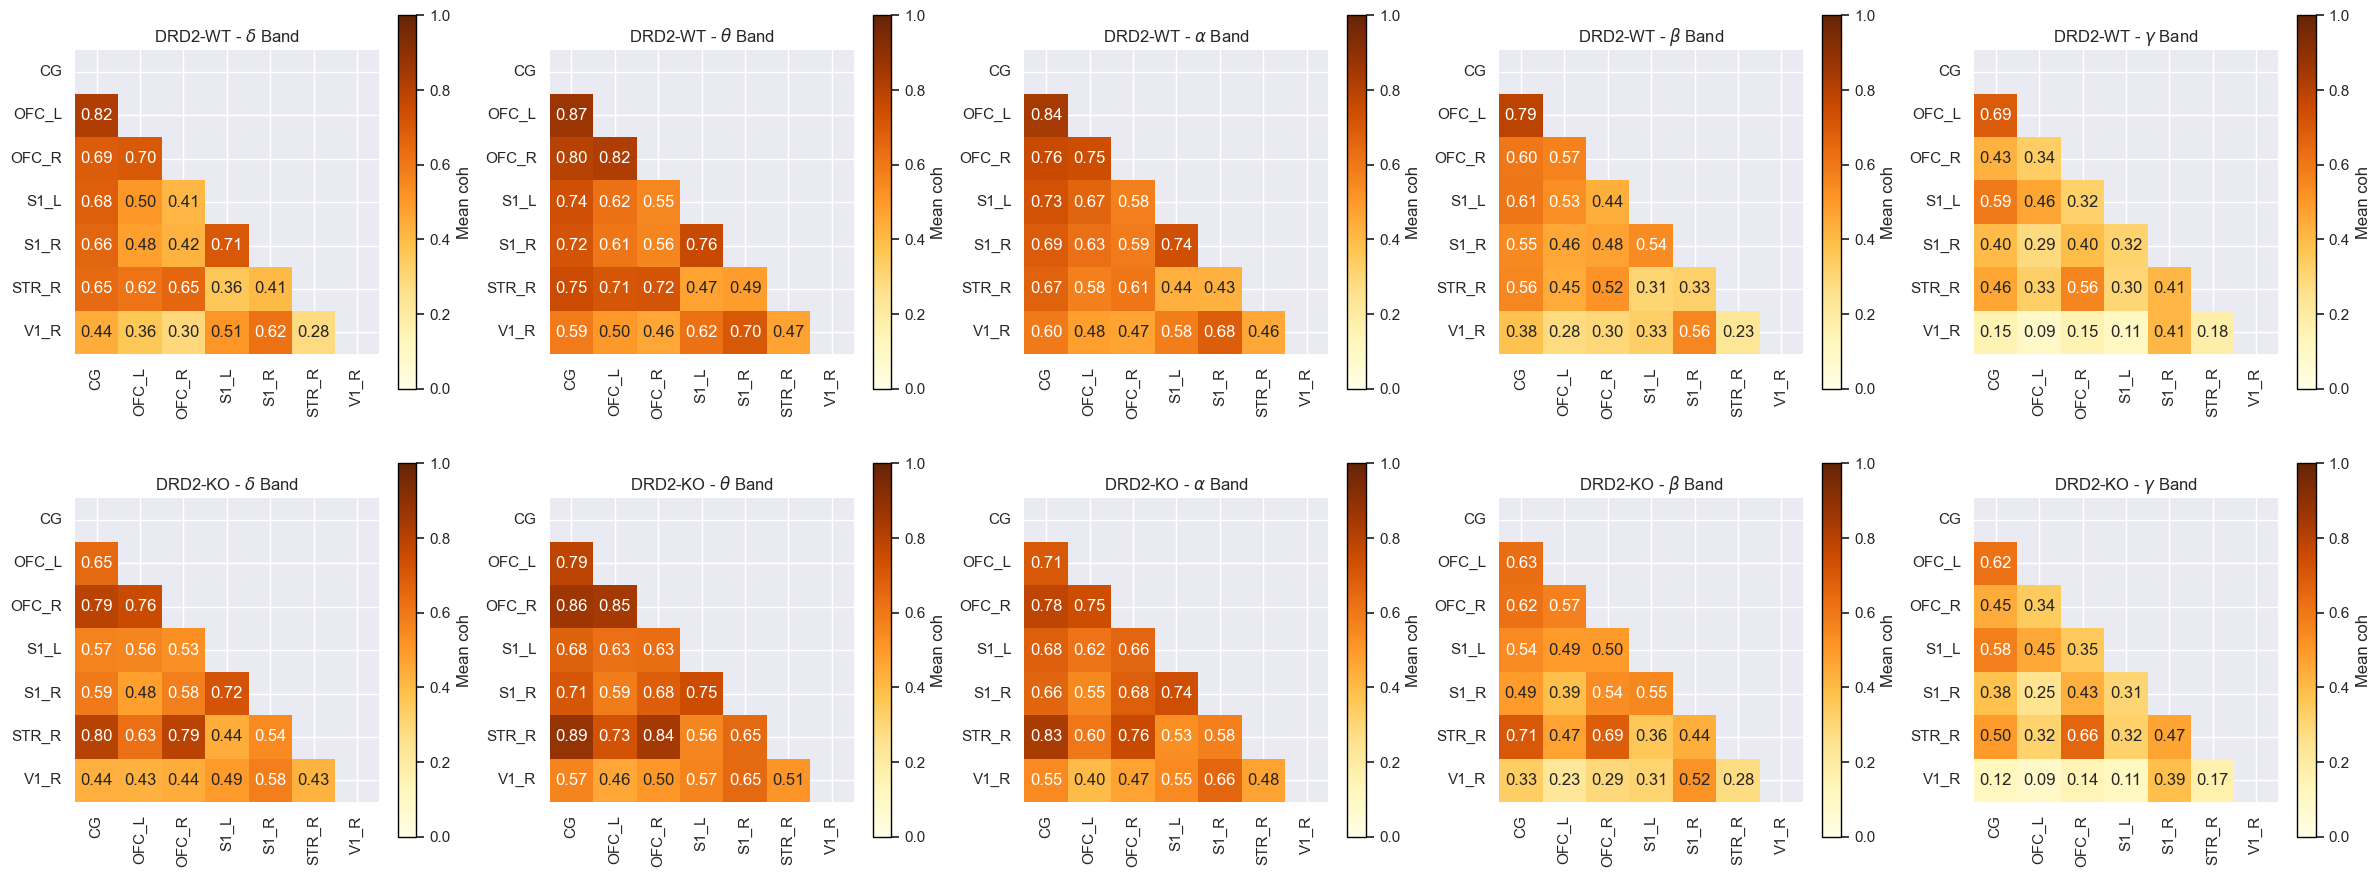

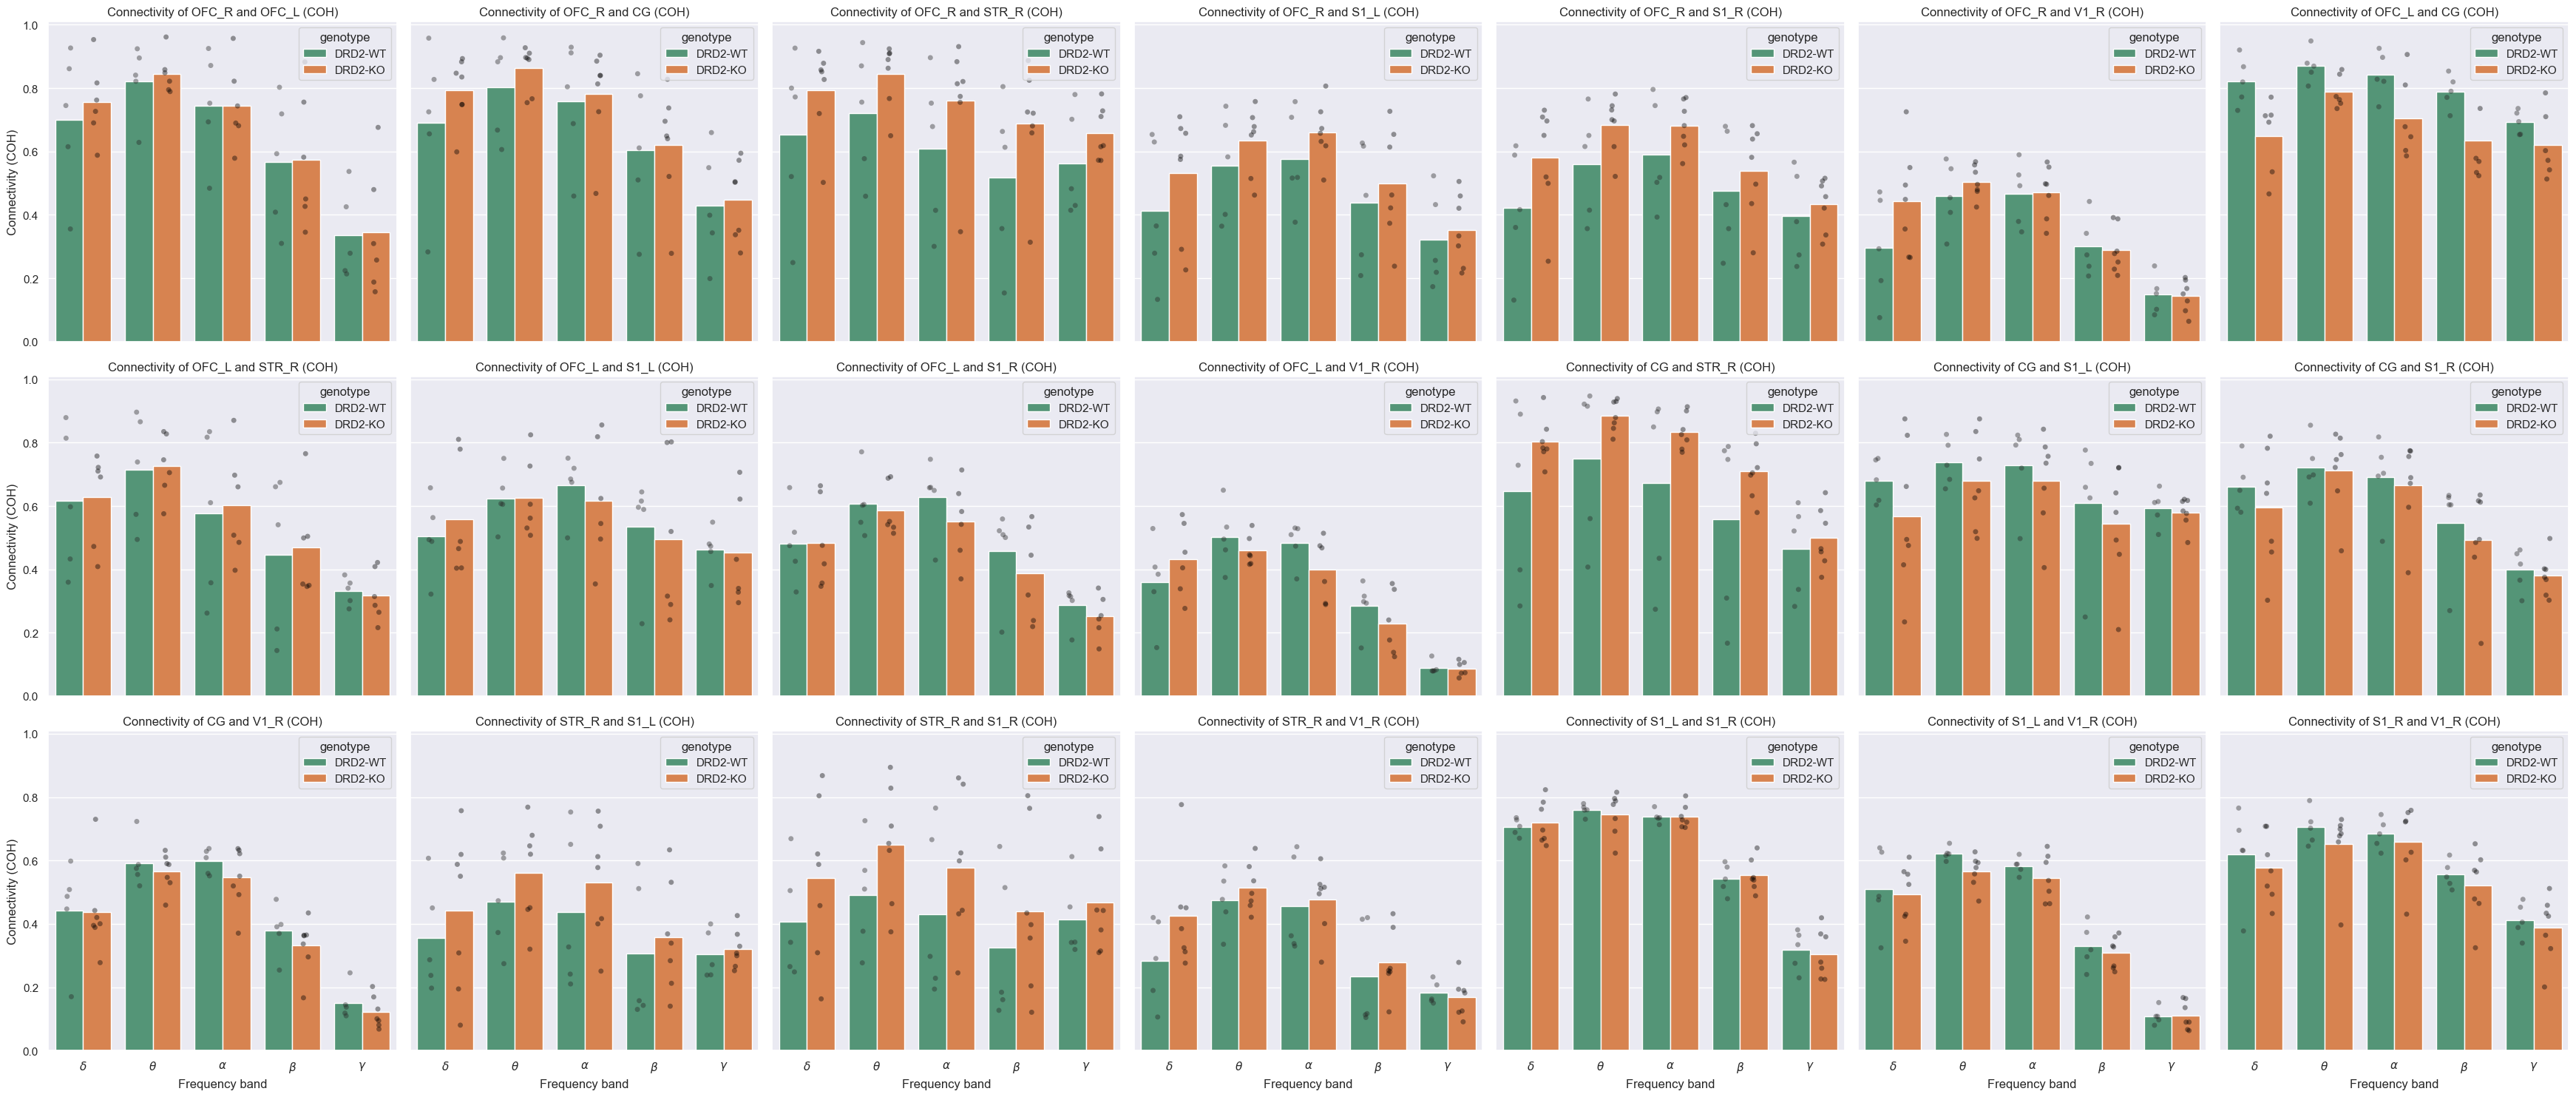

In [110]:
generate_grid_plot_wt_vs_ko(coh)
generate_barplots(coh)

#### Phase Lag Index (PLI)

In [111]:
pli = connectivity_df(all_subject_epochs, passed_subject_ids, "pli")
pli.head()

Computing pli connectivity for subjects:
 [39508, 79602, 80620, 80630, 81207, 78211, 78227, 79592, 79593, 80625, 81175, 81218]
Not computing connectivity measure for subject 39489 because of quality


C:\Users\Olle de Jong\AppData\Local\Temp\ipykernel_1972\398803393.py:3: RuntimeWarning: fmin=1.000 Hz corresponds to 4.999 < 5 cycles based on the epoch length 4.999 sec, need at least 5.000 sec epochs or fmin=1.000. Spectrum estimate will be unreliable.
  con = spectral_connectivity_epochs(
C:\Users\Olle de Jong\AppData\Local\Temp\ipykernel_1972\398803393.py:3: RuntimeWarning: fmin=1.000 Hz corresponds to 4.999 < 5 cycles based on the epoch length 4.999 sec, need at least 5.000 sec epochs or fmin=1.000. Spectrum estimate will be unreliable.
  con = spectral_connectivity_epochs(
C:\Users\Olle de Jong\AppData\Local\Temp\ipykernel_1972\398803393.py:3: RuntimeWarning: fmin=1.000 Hz corresponds to 4.999 < 5 cycles based on the epoch length 4.999 sec, need at least 5.000 sec epochs or fmin=1.000. Spectrum estimate will be unreliable.
  con = spectral_connectivity_epochs(
C:\Users\Olle de Jong\AppData\Local\Temp\ipykernel_1972\398803393.py:3: RuntimeWarning: fmin=1.000 Hz corresponds to 4.99

Not computing connectivity measure for subject 79604 because of quality


C:\Users\Olle de Jong\AppData\Local\Temp\ipykernel_1972\398803393.py:3: RuntimeWarning: fmin=1.000 Hz corresponds to 4.999 < 5 cycles based on the epoch length 4.999 sec, need at least 5.000 sec epochs or fmin=1.000. Spectrum estimate will be unreliable.
  con = spectral_connectivity_epochs(
C:\Users\Olle de Jong\AppData\Local\Temp\ipykernel_1972\398803393.py:3: RuntimeWarning: fmin=1.000 Hz corresponds to 4.999 < 5 cycles based on the epoch length 4.999 sec, need at least 5.000 sec epochs or fmin=1.000. Spectrum estimate will be unreliable.
  con = spectral_connectivity_epochs(
C:\Users\Olle de Jong\AppData\Local\Temp\ipykernel_1972\398803393.py:3: RuntimeWarning: fmin=1.000 Hz corresponds to 4.999 < 5 cycles based on the epoch length 4.999 sec, need at least 5.000 sec epochs or fmin=1.000. Spectrum estimate will be unreliable.
  con = spectral_connectivity_epochs(
C:\Users\Olle de Jong\AppData\Local\Temp\ipykernel_1972\398803393.py:3: RuntimeWarning: fmin=1.000 Hz corresponds to 4.99

Not computing connectivity measure for subject 81193 because of quality


C:\Users\Olle de Jong\AppData\Local\Temp\ipykernel_1972\398803393.py:3: RuntimeWarning: fmin=1.000 Hz corresponds to 4.999 < 5 cycles based on the epoch length 4.999 sec, need at least 5.000 sec epochs or fmin=1.000. Spectrum estimate will be unreliable.
  con = spectral_connectivity_epochs(


Not computing connectivity measure for subject 81217 because of quality


C:\Users\Olle de Jong\AppData\Local\Temp\ipykernel_1972\398803393.py:3: RuntimeWarning: fmin=1.000 Hz corresponds to 4.999 < 5 cycles based on the epoch length 4.999 sec, need at least 5.000 sec epochs or fmin=1.000. Spectrum estimate will be unreliable.
  con = spectral_connectivity_epochs(


Done computing pli connectivity.


con  node1  node2      band  subject_id genotype method
0  0.174359  OFC_R  OFC_L  $\delta$       39508  DRD2-WT    pli
1  0.302564  OFC_R     CG  $\delta$       39508  DRD2-WT    pli
2  0.594872  OFC_R  STR_R  $\delta$       39508  DRD2-WT    pli
3  0.410256  OFC_R   S1_L  $\delta$       39508  DRD2-WT    pli
4  0.230769  OFC_R   S1_R  $\delta$       39508  DRD2-WT    pli

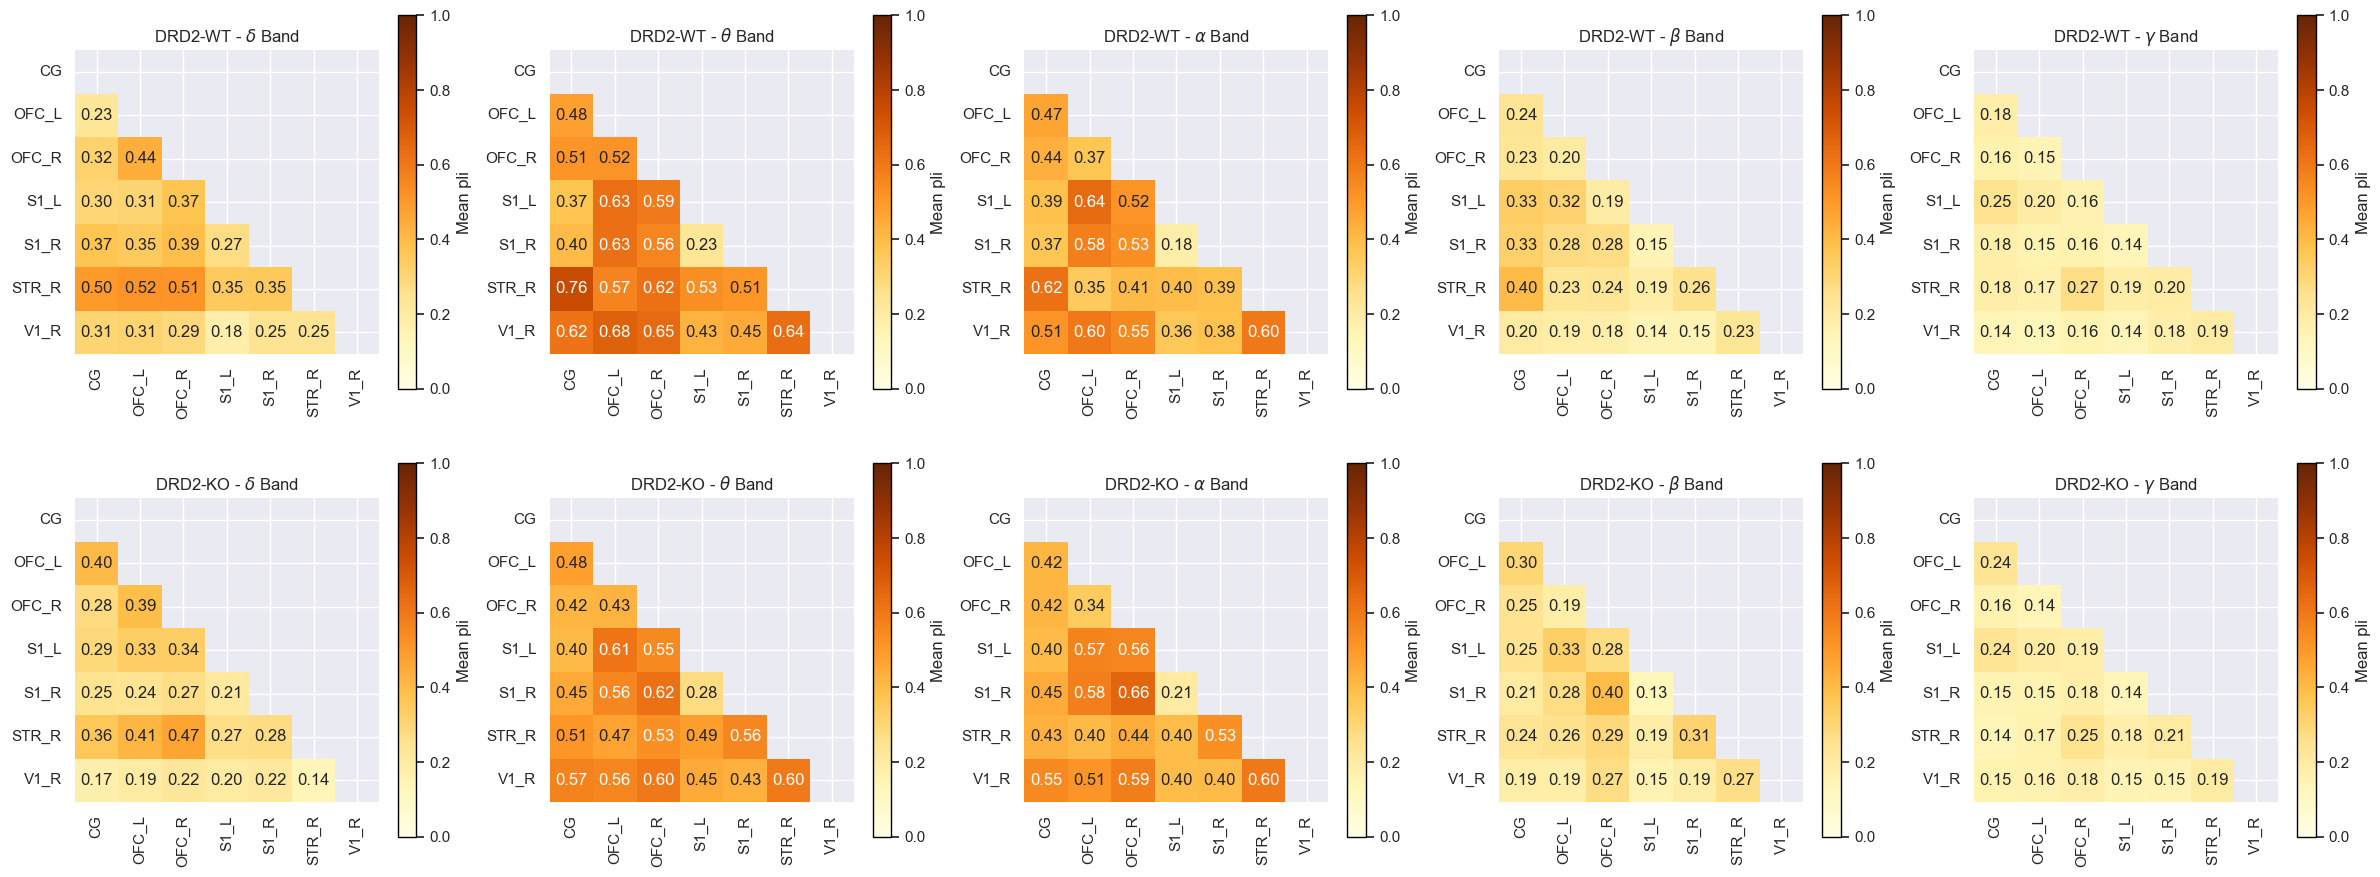

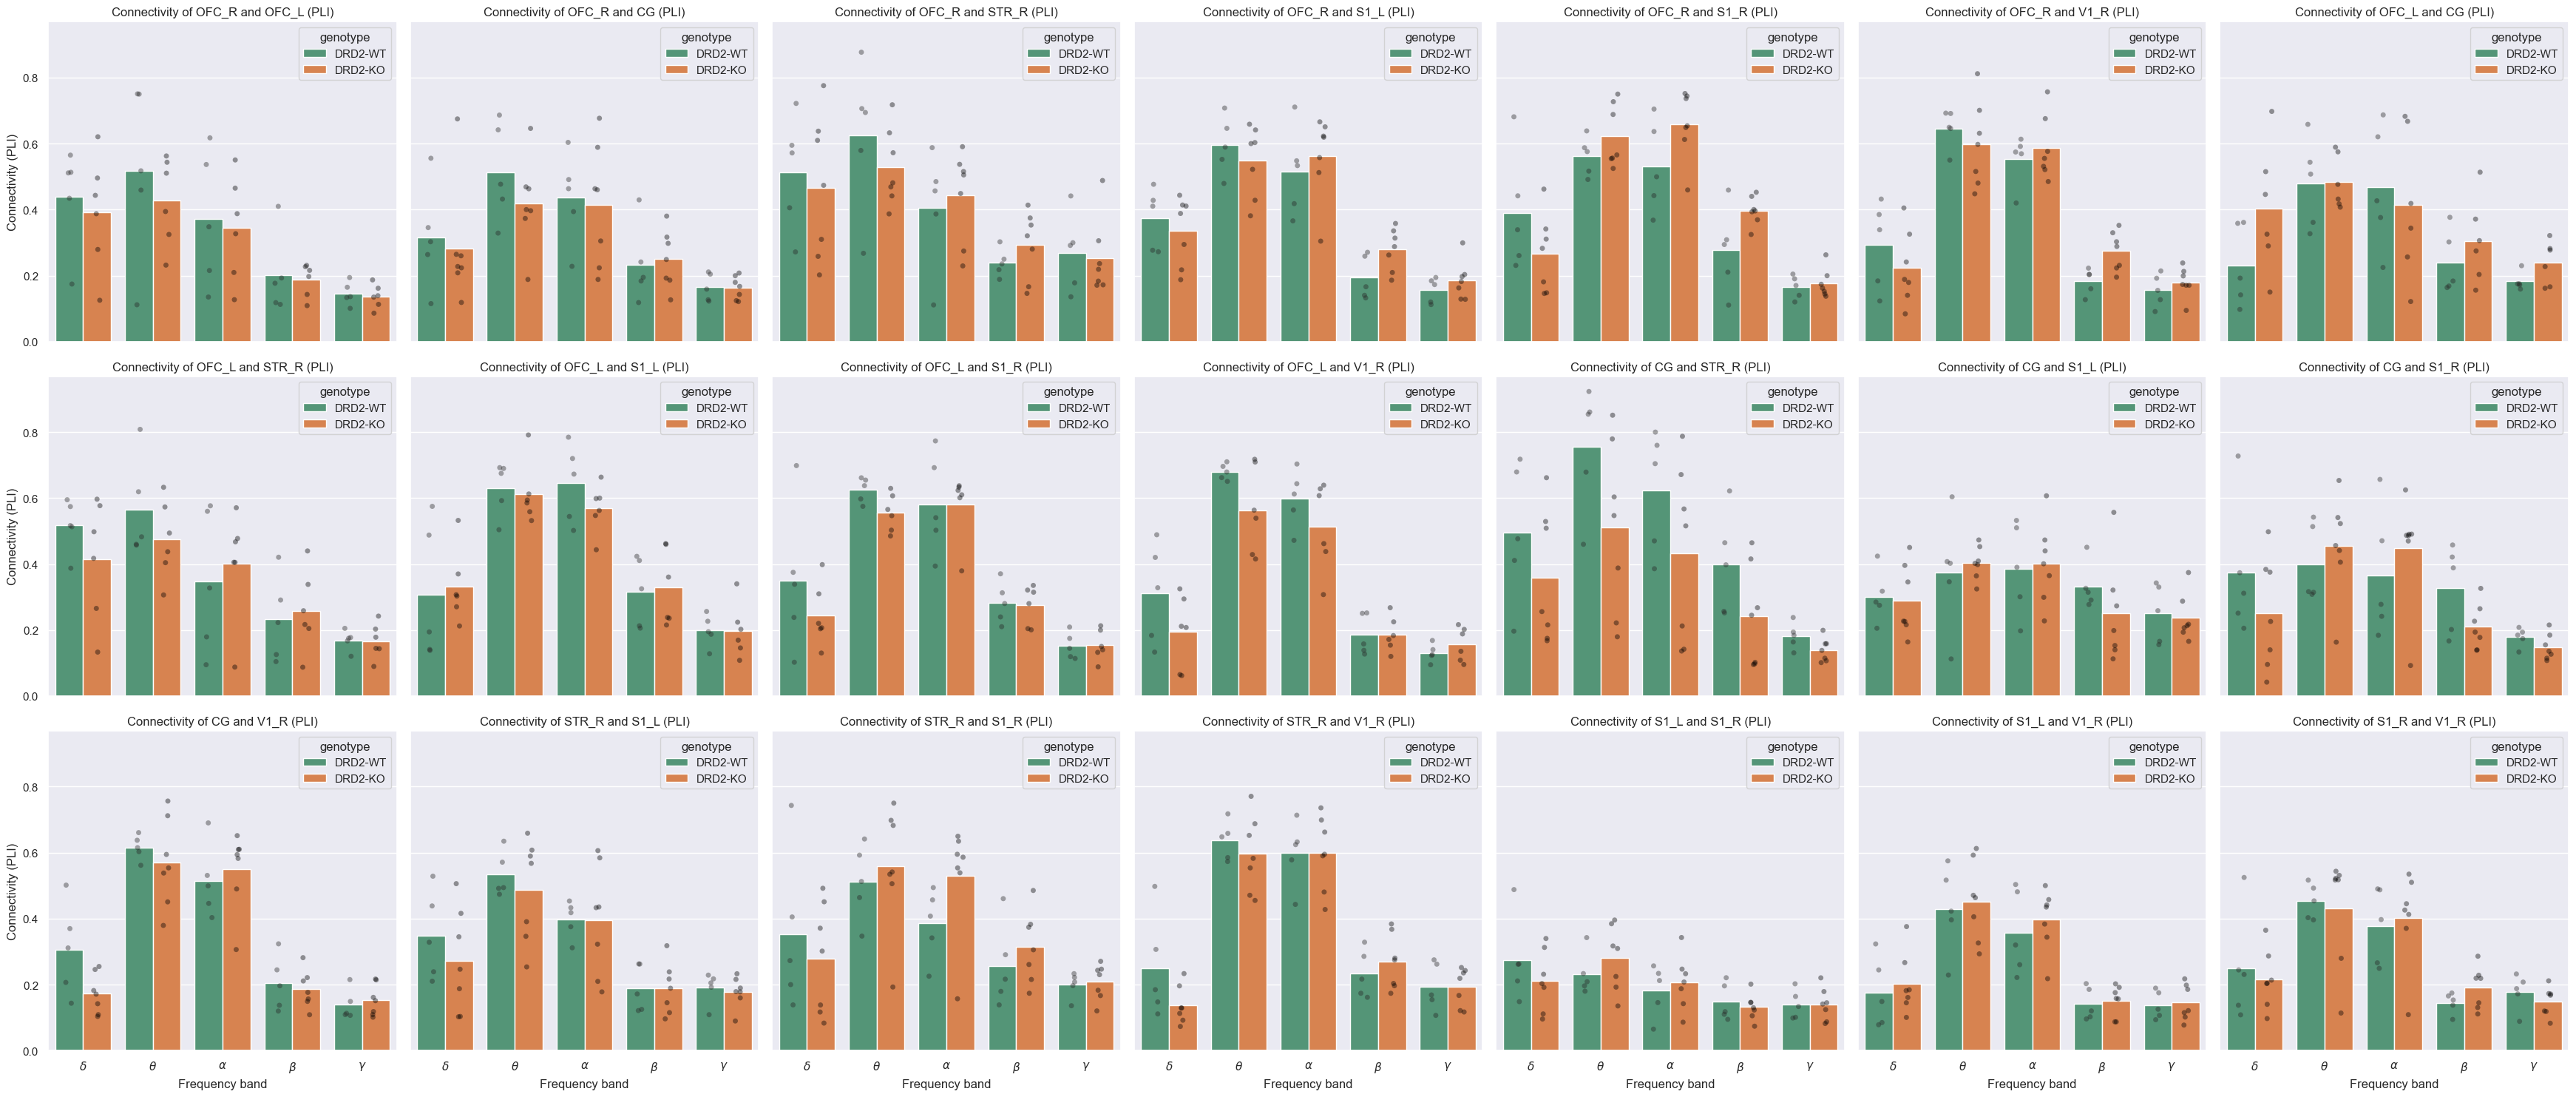

In [112]:
generate_grid_plot_wt_vs_ko(pli)
generate_barplots(pli)

#### Directed Phase Lag Index (dPLI)

In [113]:
dpli = connectivity_df(all_subject_epochs, passed_subject_ids, "dpli")
dpli.head()

Computing dpli connectivity for subjects:
 [39508, 79602, 80620, 80630, 81207, 78211, 78227, 79592, 79593, 80625, 81175, 81218]
Not computing connectivity measure for subject 39489 because of quality


C:\Users\Olle de Jong\AppData\Local\Temp\ipykernel_1972\398803393.py:3: RuntimeWarning: fmin=1.000 Hz corresponds to 4.999 < 5 cycles based on the epoch length 4.999 sec, need at least 5.000 sec epochs or fmin=1.000. Spectrum estimate will be unreliable.
  con = spectral_connectivity_epochs(
C:\Users\Olle de Jong\AppData\Local\Temp\ipykernel_1972\398803393.py:3: RuntimeWarning: fmin=1.000 Hz corresponds to 4.999 < 5 cycles based on the epoch length 4.999 sec, need at least 5.000 sec epochs or fmin=1.000. Spectrum estimate will be unreliable.
  con = spectral_connectivity_epochs(
C:\Users\Olle de Jong\AppData\Local\Temp\ipykernel_1972\398803393.py:3: RuntimeWarning: fmin=1.000 Hz corresponds to 4.999 < 5 cycles based on the epoch length 4.999 sec, need at least 5.000 sec epochs or fmin=1.000. Spectrum estimate will be unreliable.
  con = spectral_connectivity_epochs(
C:\Users\Olle de Jong\AppData\Local\Temp\ipykernel_1972\398803393.py:3: RuntimeWarning: fmin=1.000 Hz corresponds to 4.99

Not computing connectivity measure for subject 79604 because of quality


C:\Users\Olle de Jong\AppData\Local\Temp\ipykernel_1972\398803393.py:3: RuntimeWarning: fmin=1.000 Hz corresponds to 4.999 < 5 cycles based on the epoch length 4.999 sec, need at least 5.000 sec epochs or fmin=1.000. Spectrum estimate will be unreliable.
  con = spectral_connectivity_epochs(
C:\Users\Olle de Jong\AppData\Local\Temp\ipykernel_1972\398803393.py:3: RuntimeWarning: fmin=1.000 Hz corresponds to 4.999 < 5 cycles based on the epoch length 4.999 sec, need at least 5.000 sec epochs or fmin=1.000. Spectrum estimate will be unreliable.
  con = spectral_connectivity_epochs(
C:\Users\Olle de Jong\AppData\Local\Temp\ipykernel_1972\398803393.py:3: RuntimeWarning: fmin=1.000 Hz corresponds to 4.999 < 5 cycles based on the epoch length 4.999 sec, need at least 5.000 sec epochs or fmin=1.000. Spectrum estimate will be unreliable.
  con = spectral_connectivity_epochs(
C:\Users\Olle de Jong\AppData\Local\Temp\ipykernel_1972\398803393.py:3: RuntimeWarning: fmin=1.000 Hz corresponds to 4.99

Not computing connectivity measure for subject 81193 because of quality


C:\Users\Olle de Jong\AppData\Local\Temp\ipykernel_1972\398803393.py:3: RuntimeWarning: fmin=1.000 Hz corresponds to 4.999 < 5 cycles based on the epoch length 4.999 sec, need at least 5.000 sec epochs or fmin=1.000. Spectrum estimate will be unreliable.
  con = spectral_connectivity_epochs(


Not computing connectivity measure for subject 81217 because of quality


C:\Users\Olle de Jong\AppData\Local\Temp\ipykernel_1972\398803393.py:3: RuntimeWarning: fmin=1.000 Hz corresponds to 4.999 < 5 cycles based on the epoch length 4.999 sec, need at least 5.000 sec epochs or fmin=1.000. Spectrum estimate will be unreliable.
  con = spectral_connectivity_epochs(


Done computing dpli connectivity.


con  node1  node2      band  subject_id genotype method
0  0.582051  OFC_R  OFC_L  $\delta$       39508  DRD2-WT   dpli
1  0.651282  OFC_R     CG  $\delta$       39508  DRD2-WT   dpli
2  0.202564  OFC_R  STR_R  $\delta$       39508  DRD2-WT   dpli
3  0.705128  OFC_R   S1_L  $\delta$       39508  DRD2-WT   dpli
4  0.615385  OFC_R   S1_R  $\delta$       39508  DRD2-WT   dpli

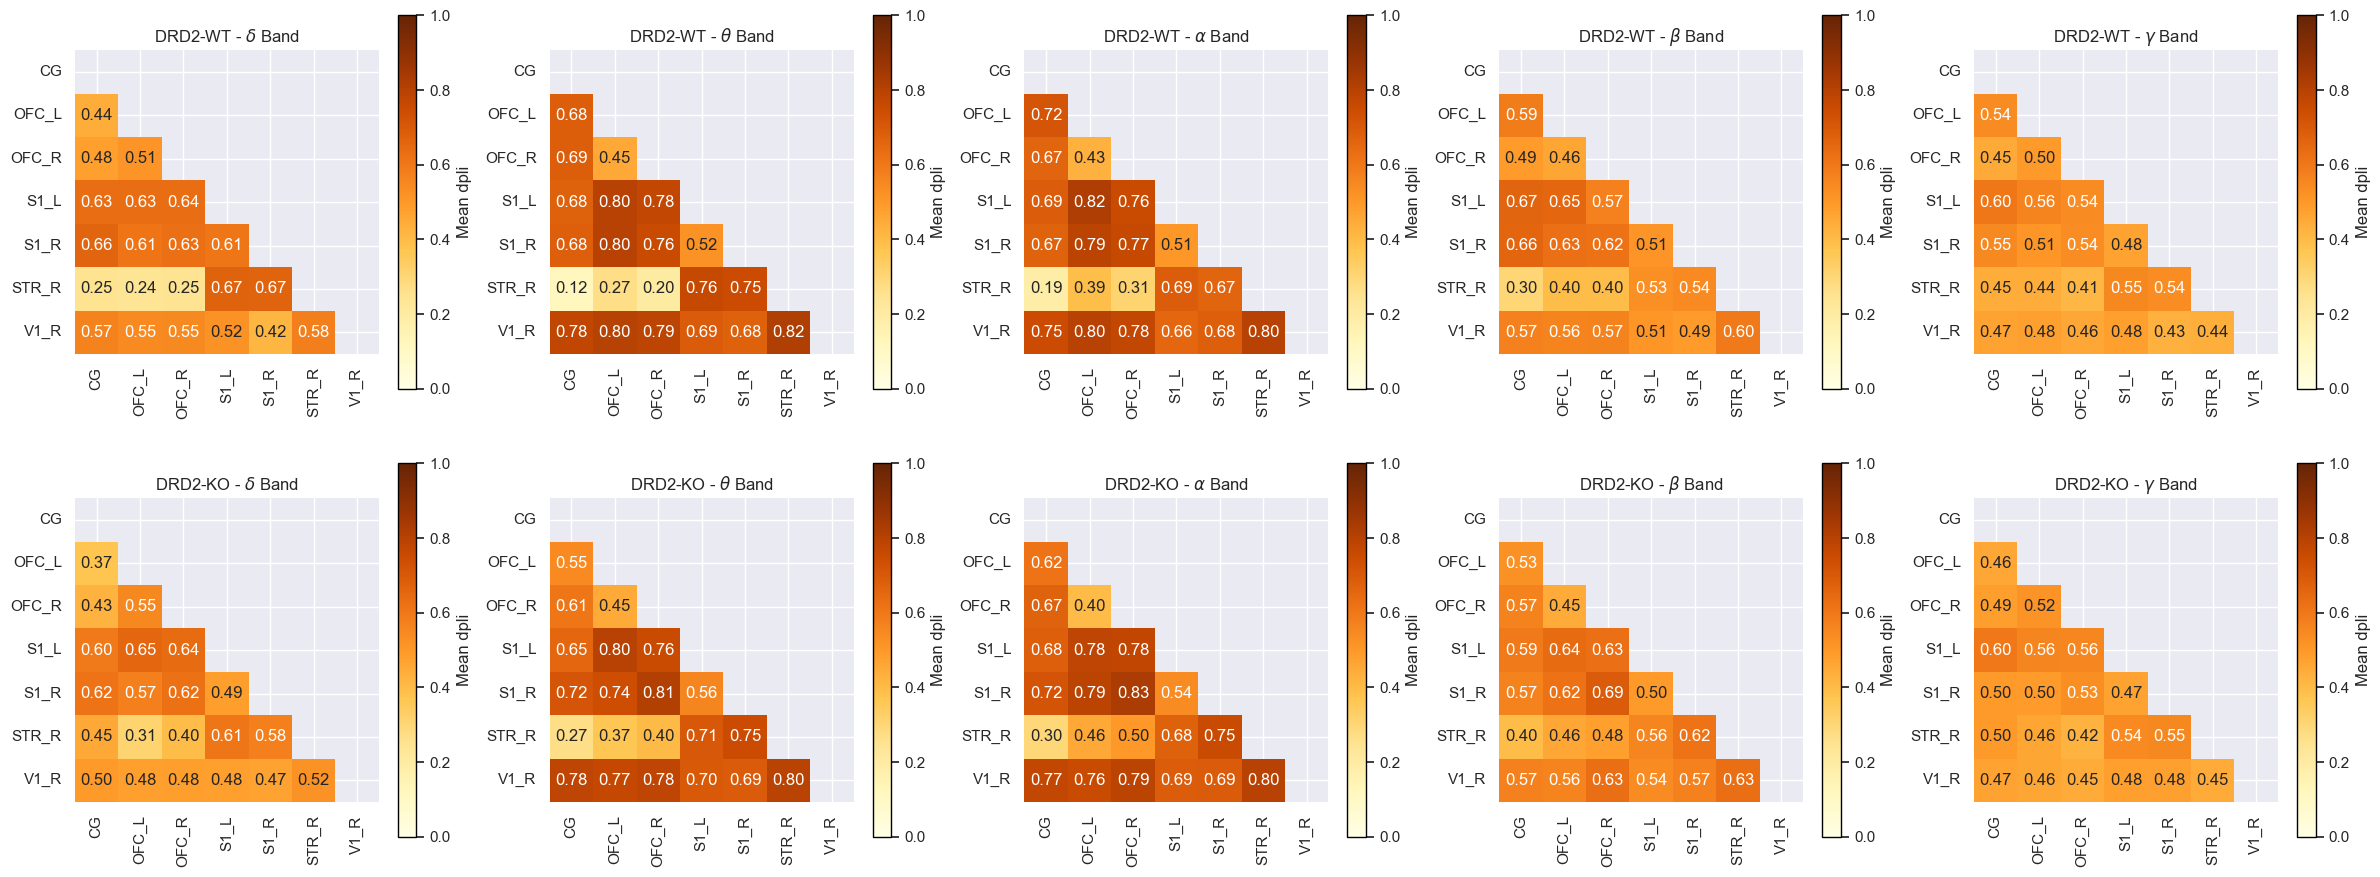

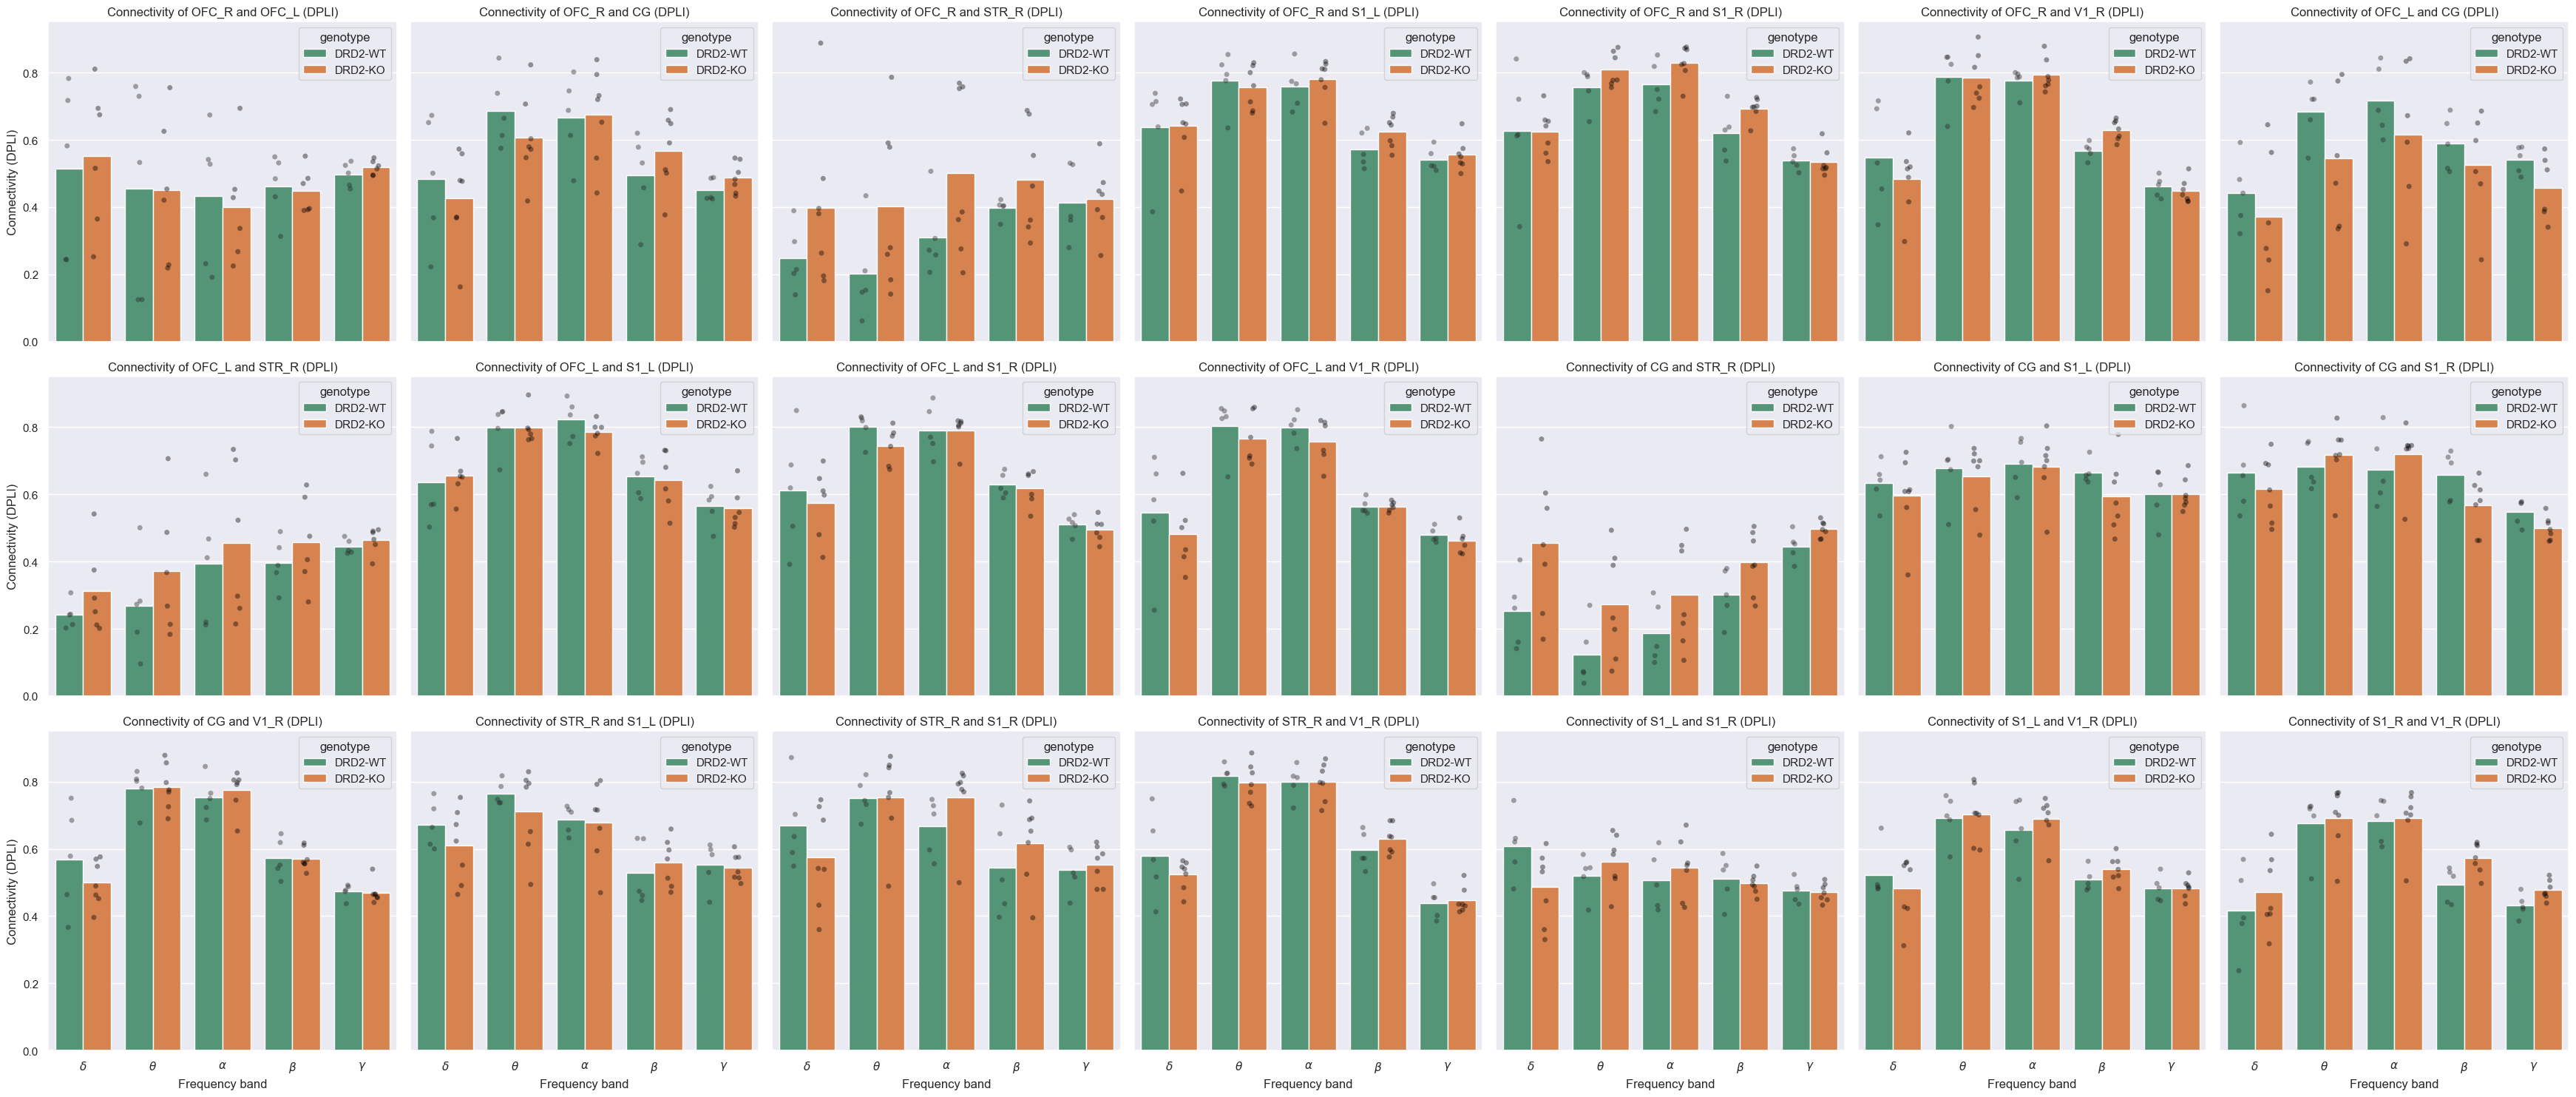

In [114]:
generate_grid_plot_wt_vs_ko(dpli)
generate_barplots(dpli)

When it comes to dPLI. The reference (first provided signal) is lagging the other signal if dPLI is between 0 and 0.5, and the reference signal is leading the other signal is the dPLI is between 0.5 and 1.0.

In the heatmaps we create here, the first provided signal is always on the 

#### Weighted Phase Lag Index (wPLI)

In [115]:
wpli = connectivity_df(all_subject_epochs, passed_subject_ids, "wpli")
wpli.head()

Computing wpli connectivity for subjects:
 [39508, 79602, 80620, 80630, 81207, 78211, 78227, 79592, 79593, 80625, 81175, 81218]
Not computing connectivity measure for subject 39489 because of quality


C:\Users\Olle de Jong\AppData\Local\Temp\ipykernel_1972\398803393.py:3: RuntimeWarning: fmin=1.000 Hz corresponds to 4.999 < 5 cycles based on the epoch length 4.999 sec, need at least 5.000 sec epochs or fmin=1.000. Spectrum estimate will be unreliable.
  con = spectral_connectivity_epochs(
C:\Users\Olle de Jong\AppData\Local\Temp\ipykernel_1972\398803393.py:3: RuntimeWarning: fmin=1.000 Hz corresponds to 4.999 < 5 cycles based on the epoch length 4.999 sec, need at least 5.000 sec epochs or fmin=1.000. Spectrum estimate will be unreliable.
  con = spectral_connectivity_epochs(
C:\Users\Olle de Jong\AppData\Local\Temp\ipykernel_1972\398803393.py:3: RuntimeWarning: fmin=1.000 Hz corresponds to 4.999 < 5 cycles based on the epoch length 4.999 sec, need at least 5.000 sec epochs or fmin=1.000. Spectrum estimate will be unreliable.
  con = spectral_connectivity_epochs(
C:\Users\Olle de Jong\AppData\Local\Temp\ipykernel_1972\398803393.py:3: RuntimeWarning: fmin=1.000 Hz corresponds to 4.99

Not computing connectivity measure for subject 79604 because of quality


C:\Users\Olle de Jong\AppData\Local\Temp\ipykernel_1972\398803393.py:3: RuntimeWarning: fmin=1.000 Hz corresponds to 4.999 < 5 cycles based on the epoch length 4.999 sec, need at least 5.000 sec epochs or fmin=1.000. Spectrum estimate will be unreliable.
  con = spectral_connectivity_epochs(
C:\Users\Olle de Jong\AppData\Local\Temp\ipykernel_1972\398803393.py:3: RuntimeWarning: fmin=1.000 Hz corresponds to 4.999 < 5 cycles based on the epoch length 4.999 sec, need at least 5.000 sec epochs or fmin=1.000. Spectrum estimate will be unreliable.
  con = spectral_connectivity_epochs(
C:\Users\Olle de Jong\AppData\Local\Temp\ipykernel_1972\398803393.py:3: RuntimeWarning: fmin=1.000 Hz corresponds to 4.999 < 5 cycles based on the epoch length 4.999 sec, need at least 5.000 sec epochs or fmin=1.000. Spectrum estimate will be unreliable.
  con = spectral_connectivity_epochs(
C:\Users\Olle de Jong\AppData\Local\Temp\ipykernel_1972\398803393.py:3: RuntimeWarning: fmin=1.000 Hz corresponds to 4.99

Not computing connectivity measure for subject 81193 because of quality


C:\Users\Olle de Jong\AppData\Local\Temp\ipykernel_1972\398803393.py:3: RuntimeWarning: fmin=1.000 Hz corresponds to 4.999 < 5 cycles based on the epoch length 4.999 sec, need at least 5.000 sec epochs or fmin=1.000. Spectrum estimate will be unreliable.
  con = spectral_connectivity_epochs(


Not computing connectivity measure for subject 81217 because of quality


C:\Users\Olle de Jong\AppData\Local\Temp\ipykernel_1972\398803393.py:3: RuntimeWarning: fmin=1.000 Hz corresponds to 4.999 < 5 cycles based on the epoch length 4.999 sec, need at least 5.000 sec epochs or fmin=1.000. Spectrum estimate will be unreliable.
  con = spectral_connectivity_epochs(


Done computing wpli connectivity.


con  node1  node2      band  subject_id genotype method
0  0.346771  OFC_R  OFC_L  $\delta$       39508  DRD2-WT   wpli
1  0.427274  OFC_R     CG  $\delta$       39508  DRD2-WT   wpli
2  0.891064  OFC_R  STR_R  $\delta$       39508  DRD2-WT   wpli
3  0.465942  OFC_R   S1_L  $\delta$       39508  DRD2-WT   wpli
4  0.247446  OFC_R   S1_R  $\delta$       39508  DRD2-WT   wpli

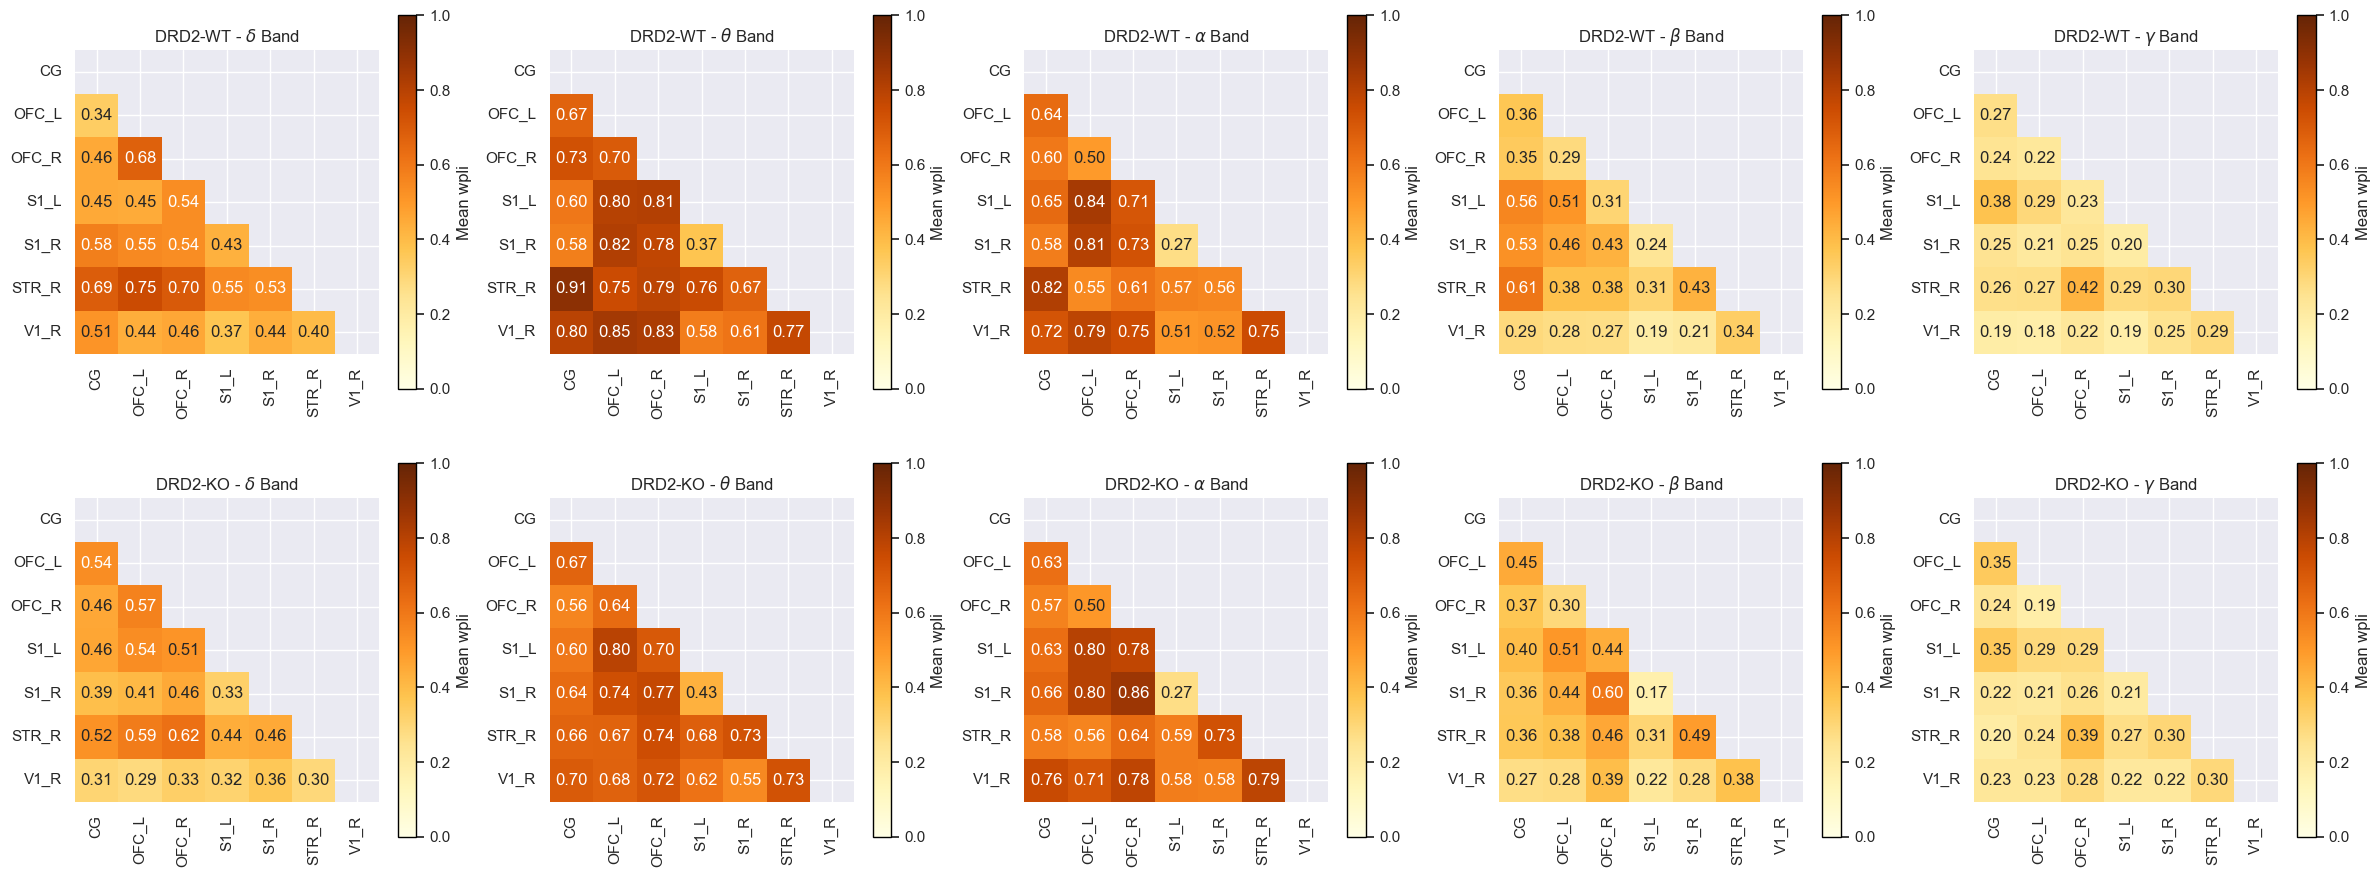

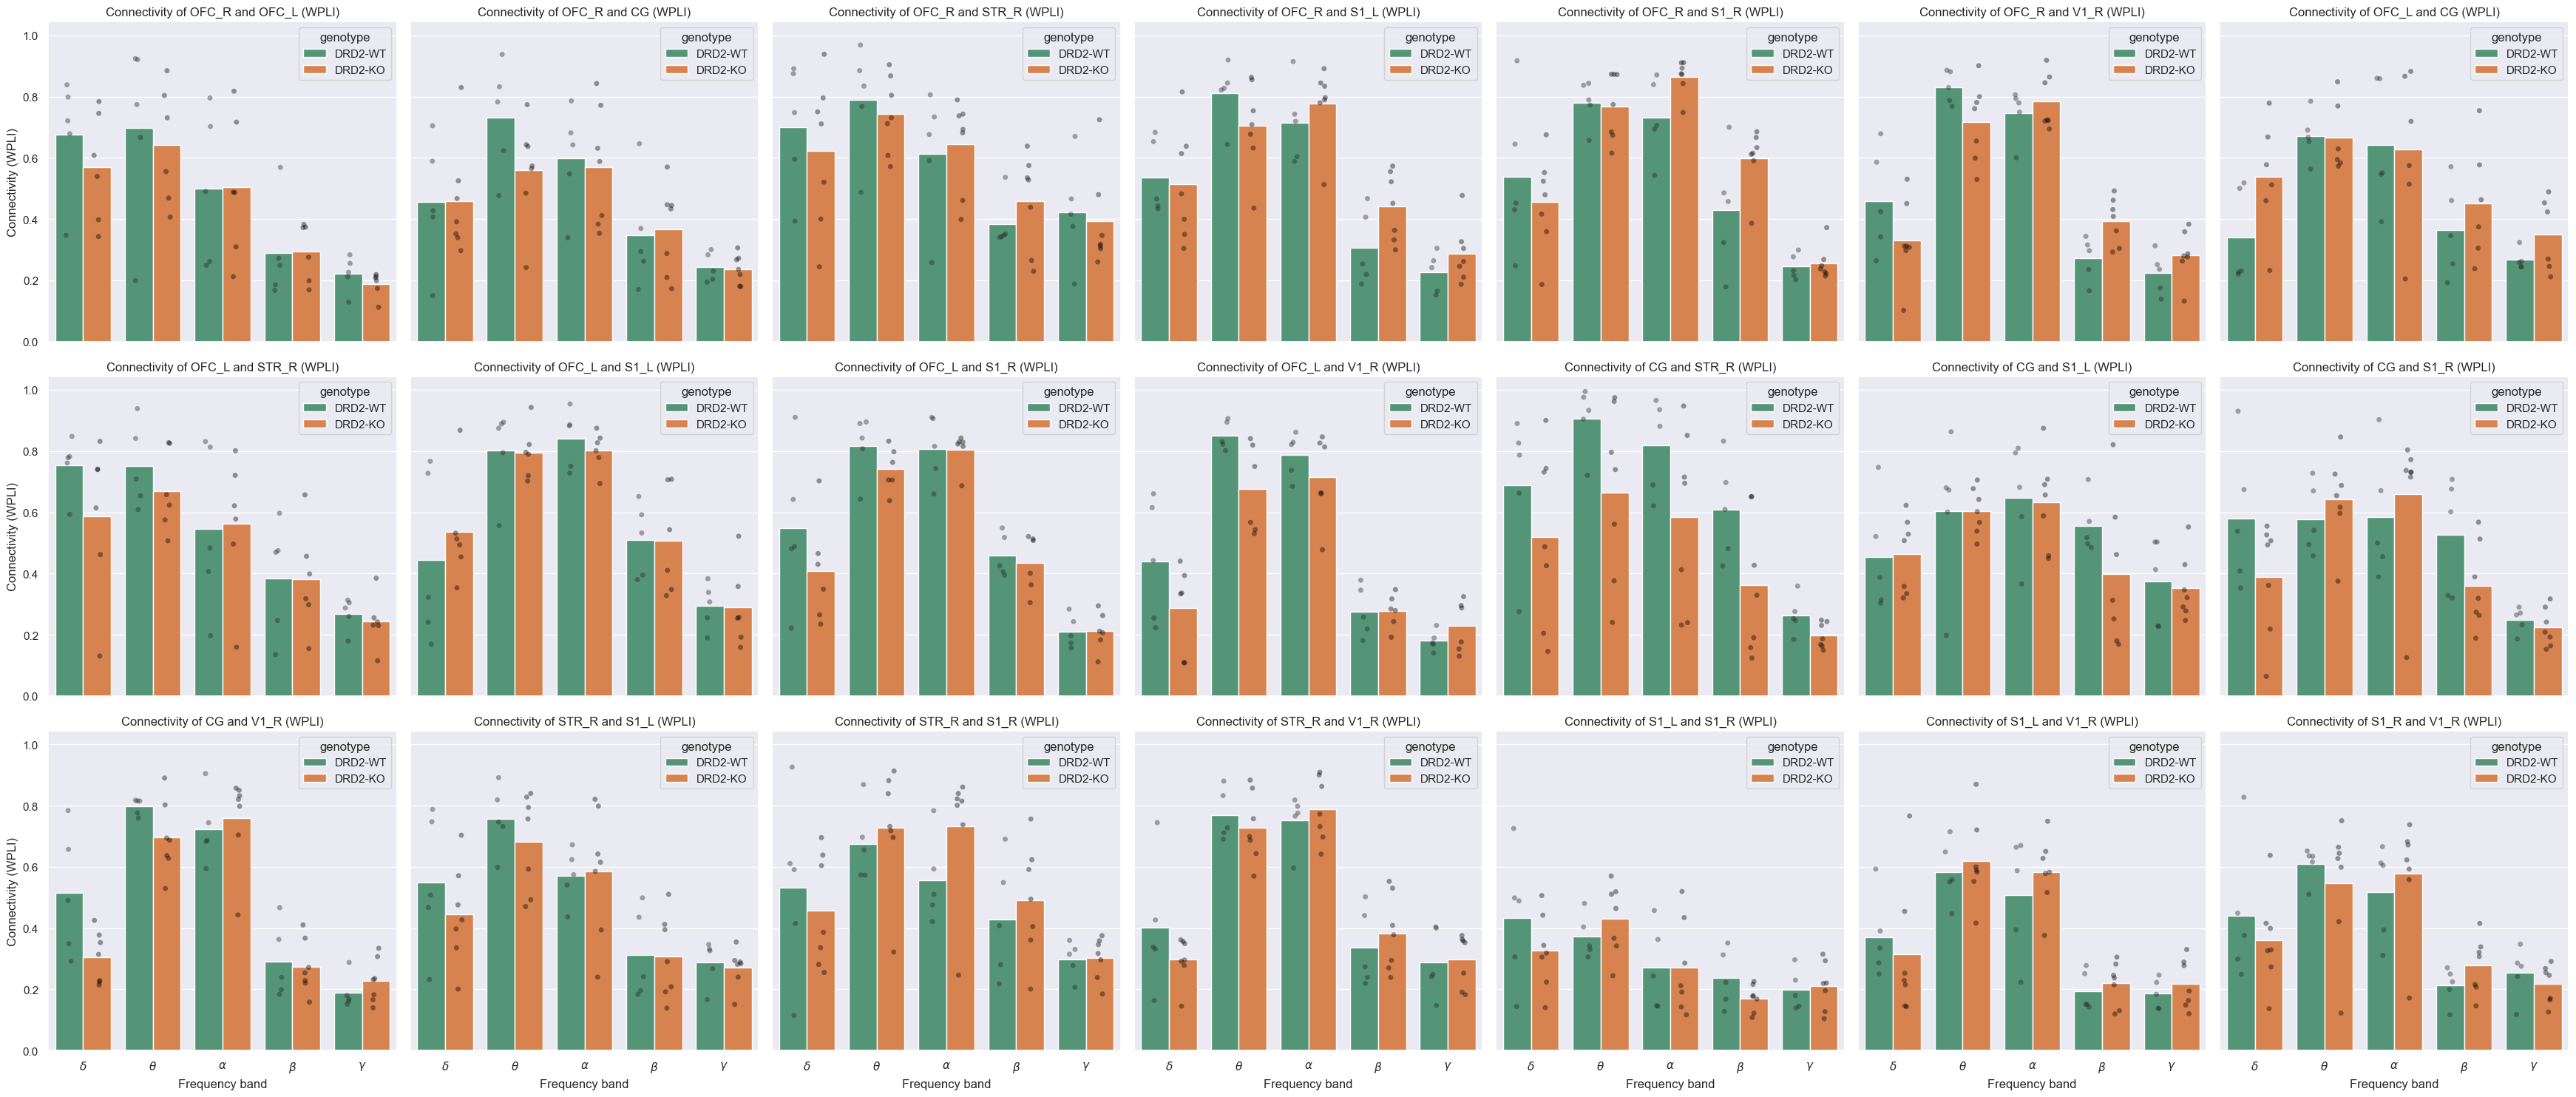

In [116]:
generate_grid_plot_wt_vs_ko(wpli)
generate_barplots(wpli)

#### Debiased estimator of squared WPLI (wPLI2 debiased)

In [117]:
wpli2 = connectivity_df(all_subject_epochs, passed_subject_ids, "wpli2_debiased")
wpli2.head()

Computing wpli2_debiased connectivity for subjects:
 [39508, 79602, 80620, 80630, 81207, 78211, 78227, 79592, 79593, 80625, 81175, 81218]
Not computing connectivity measure for subject 39489 because of quality


C:\Users\Olle de Jong\AppData\Local\Temp\ipykernel_1972\398803393.py:3: RuntimeWarning: fmin=1.000 Hz corresponds to 4.999 < 5 cycles based on the epoch length 4.999 sec, need at least 5.000 sec epochs or fmin=1.000. Spectrum estimate will be unreliable.
  con = spectral_connectivity_epochs(
C:\Users\Olle de Jong\AppData\Local\Temp\ipykernel_1972\398803393.py:3: RuntimeWarning: fmin=1.000 Hz corresponds to 4.999 < 5 cycles based on the epoch length 4.999 sec, need at least 5.000 sec epochs or fmin=1.000. Spectrum estimate will be unreliable.
  con = spectral_connectivity_epochs(
C:\Users\Olle de Jong\AppData\Local\Temp\ipykernel_1972\398803393.py:3: RuntimeWarning: fmin=1.000 Hz corresponds to 4.999 < 5 cycles based on the epoch length 4.999 sec, need at least 5.000 sec epochs or fmin=1.000. Spectrum estimate will be unreliable.
  con = spectral_connectivity_epochs(
C:\Users\Olle de Jong\AppData\Local\Temp\ipykernel_1972\398803393.py:3: RuntimeWarning: fmin=1.000 Hz corresponds to 4.99

Not computing connectivity measure for subject 79604 because of quality


C:\Users\Olle de Jong\AppData\Local\Temp\ipykernel_1972\398803393.py:3: RuntimeWarning: fmin=1.000 Hz corresponds to 4.999 < 5 cycles based on the epoch length 4.999 sec, need at least 5.000 sec epochs or fmin=1.000. Spectrum estimate will be unreliable.
  con = spectral_connectivity_epochs(
C:\Users\Olle de Jong\AppData\Local\Temp\ipykernel_1972\398803393.py:3: RuntimeWarning: fmin=1.000 Hz corresponds to 4.999 < 5 cycles based on the epoch length 4.999 sec, need at least 5.000 sec epochs or fmin=1.000. Spectrum estimate will be unreliable.
  con = spectral_connectivity_epochs(
C:\Users\Olle de Jong\AppData\Local\Temp\ipykernel_1972\398803393.py:3: RuntimeWarning: fmin=1.000 Hz corresponds to 4.999 < 5 cycles based on the epoch length 4.999 sec, need at least 5.000 sec epochs or fmin=1.000. Spectrum estimate will be unreliable.
  con = spectral_connectivity_epochs(
C:\Users\Olle de Jong\AppData\Local\Temp\ipykernel_1972\398803393.py:3: RuntimeWarning: fmin=1.000 Hz corresponds to 4.99

Not computing connectivity measure for subject 81193 because of quality


C:\Users\Olle de Jong\AppData\Local\Temp\ipykernel_1972\398803393.py:3: RuntimeWarning: fmin=1.000 Hz corresponds to 4.999 < 5 cycles based on the epoch length 4.999 sec, need at least 5.000 sec epochs or fmin=1.000. Spectrum estimate will be unreliable.
  con = spectral_connectivity_epochs(


Not computing connectivity measure for subject 81217 because of quality


C:\Users\Olle de Jong\AppData\Local\Temp\ipykernel_1972\398803393.py:3: RuntimeWarning: fmin=1.000 Hz corresponds to 4.999 < 5 cycles based on the epoch length 4.999 sec, need at least 5.000 sec epochs or fmin=1.000. Spectrum estimate will be unreliable.
  con = spectral_connectivity_epochs(


Done computing wpli2_debiased connectivity.


con  node1  node2      band  subject_id genotype          method
0  0.105801  OFC_R  OFC_L  $\delta$       39508  DRD2-WT  wpli2_debiased
1  0.171709  OFC_R     CG  $\delta$       39508  DRD2-WT  wpli2_debiased
2  0.780848  OFC_R  STR_R  $\delta$       39508  DRD2-WT  wpli2_debiased
3  0.166352  OFC_R   S1_L  $\delta$       39508  DRD2-WT  wpli2_debiased
4  0.032247  OFC_R   S1_R  $\delta$       39508  DRD2-WT  wpli2_debiased

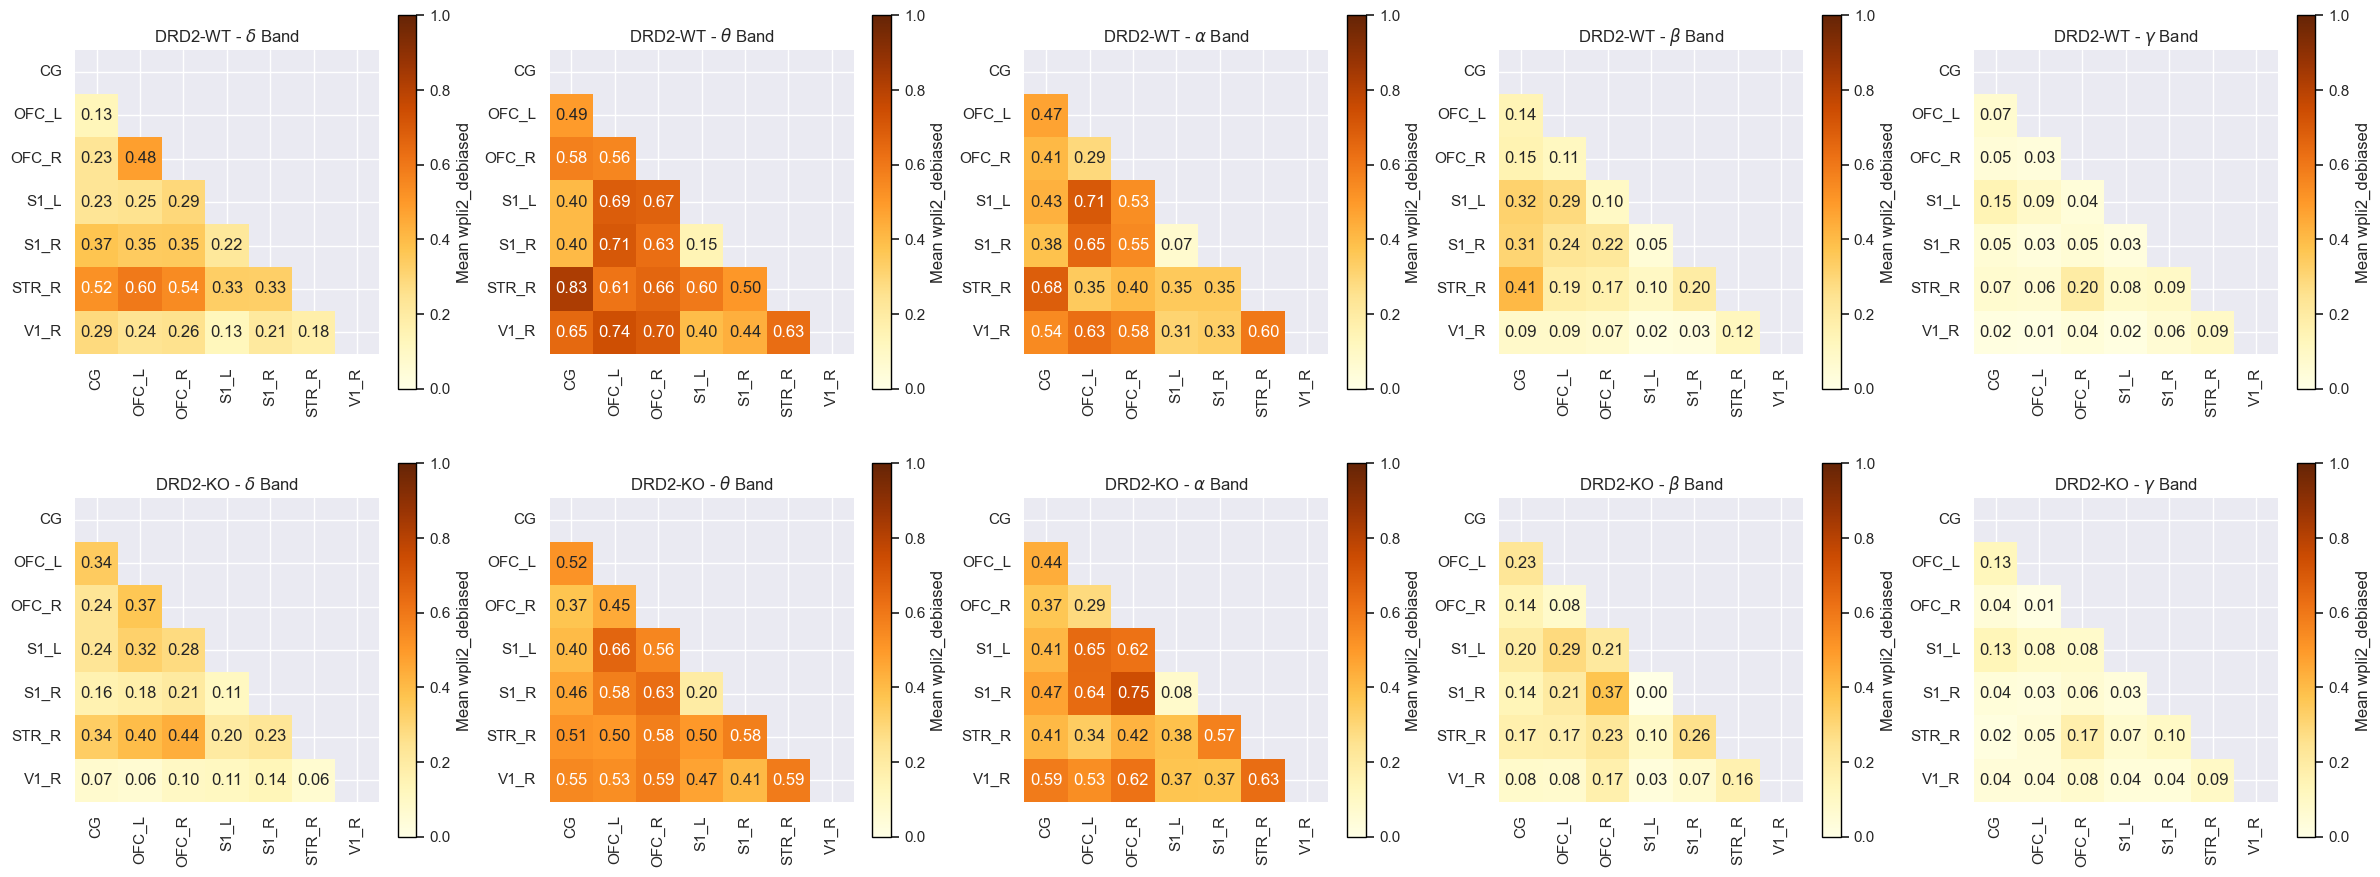

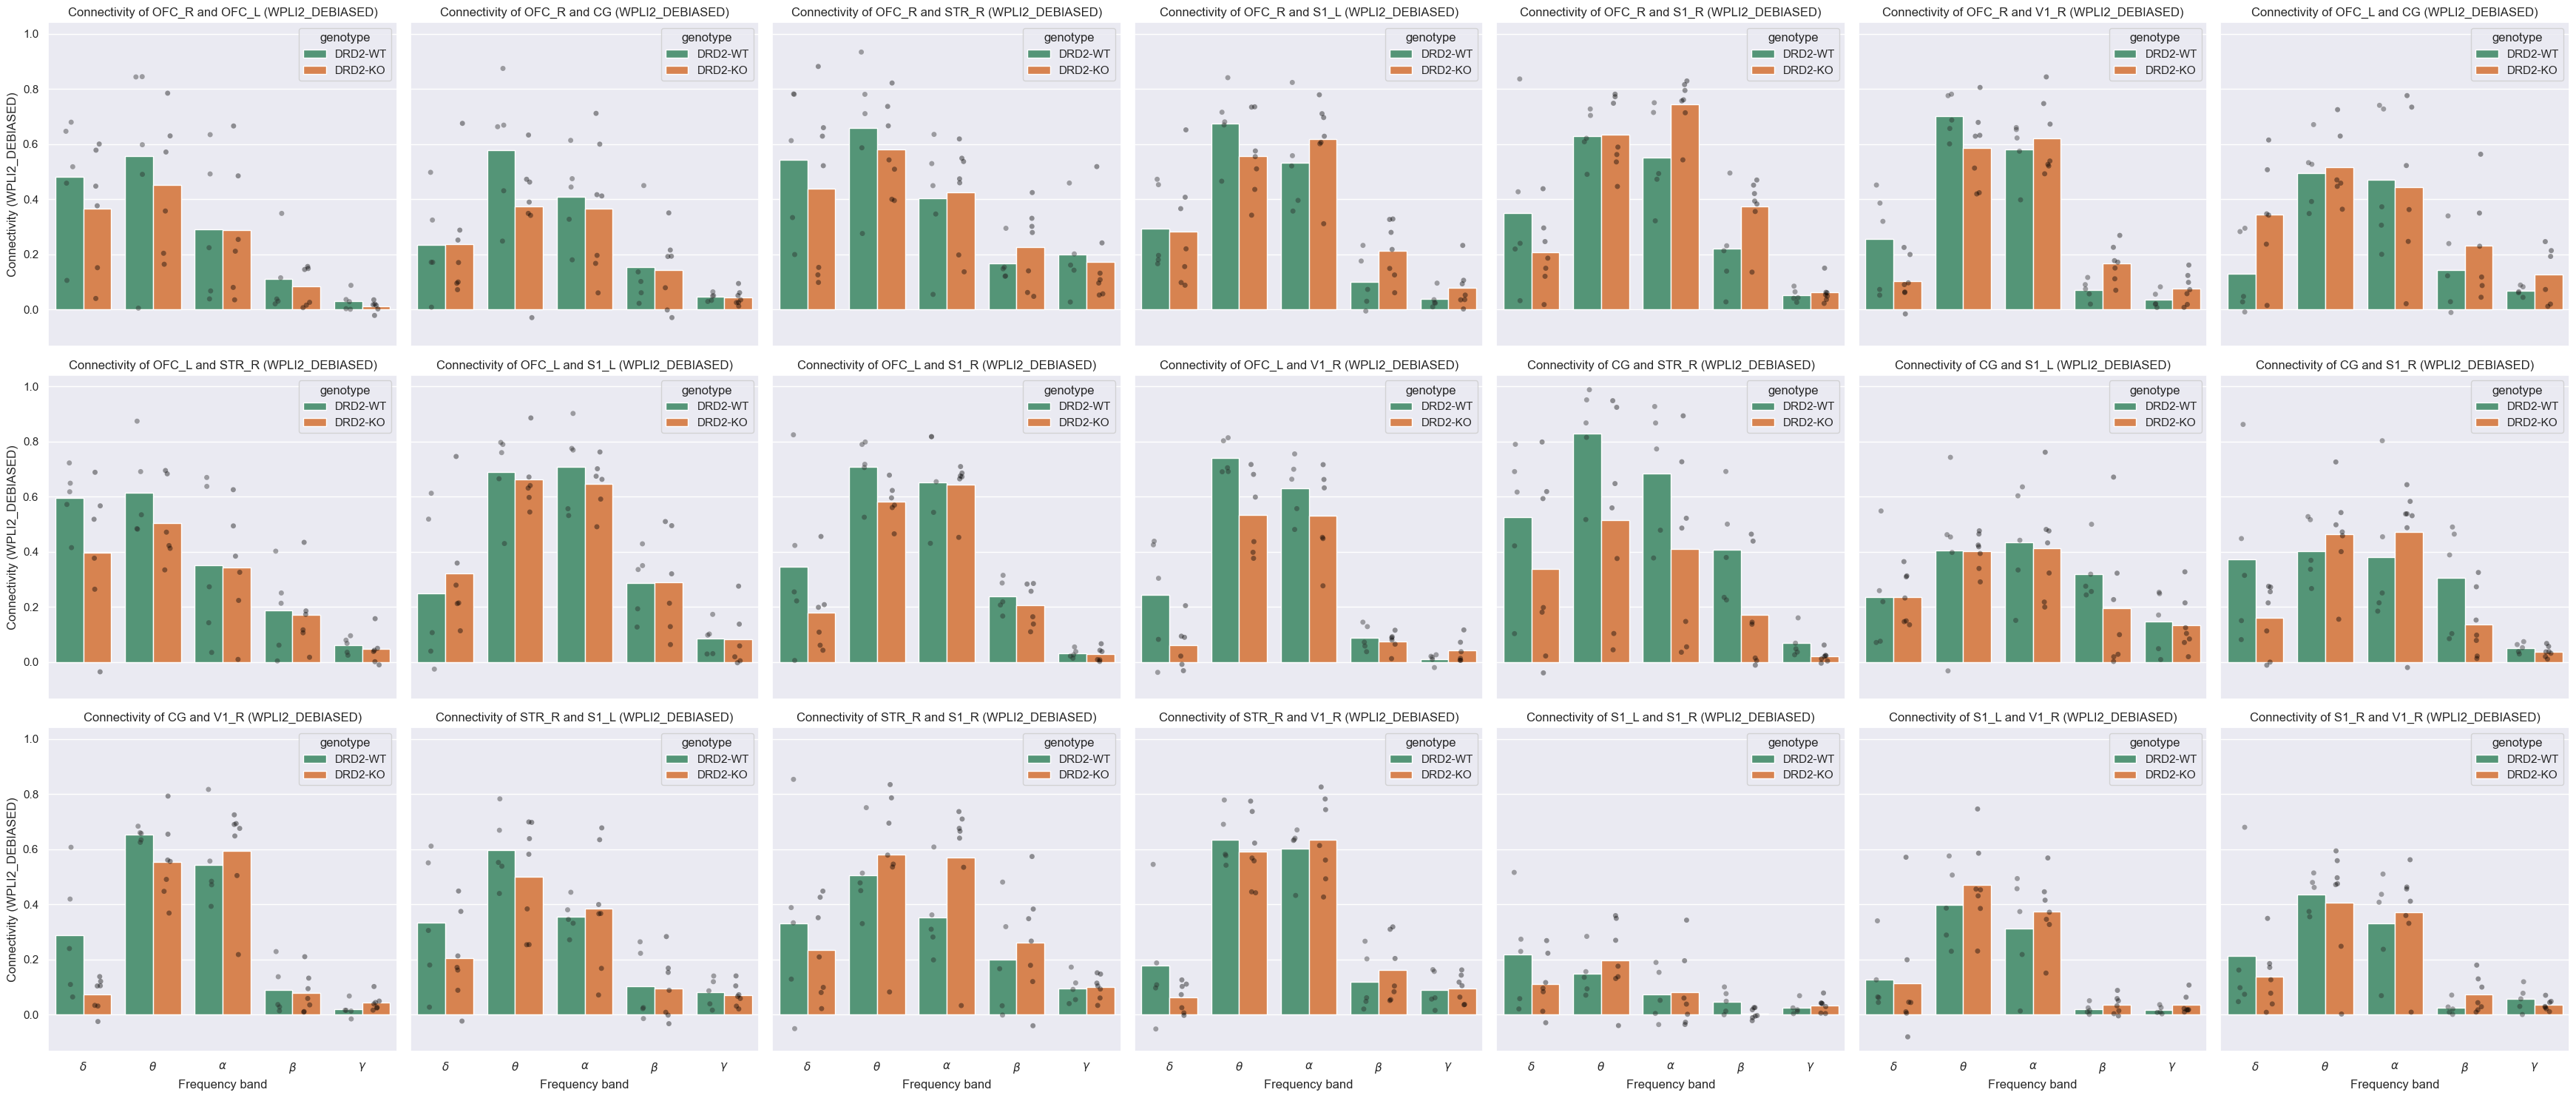

In [118]:
generate_grid_plot_wt_vs_ko(wpli2)
generate_barplots(wpli2)

#### Pairwise Phase Consistency (PPC)

In [119]:
ppc = connectivity_df(all_subject_epochs, passed_subject_ids, "ppc")
ppc.head()

Computing ppc connectivity for subjects:
 [39508, 79602, 80620, 80630, 81207, 78211, 78227, 79592, 79593, 80625, 81175, 81218]
Not computing connectivity measure for subject 39489 because of quality


C:\Users\Olle de Jong\AppData\Local\Temp\ipykernel_1972\398803393.py:3: RuntimeWarning: fmin=1.000 Hz corresponds to 4.999 < 5 cycles based on the epoch length 4.999 sec, need at least 5.000 sec epochs or fmin=1.000. Spectrum estimate will be unreliable.
  con = spectral_connectivity_epochs(
C:\Users\Olle de Jong\AppData\Local\Temp\ipykernel_1972\398803393.py:3: RuntimeWarning: fmin=1.000 Hz corresponds to 4.999 < 5 cycles based on the epoch length 4.999 sec, need at least 5.000 sec epochs or fmin=1.000. Spectrum estimate will be unreliable.
  con = spectral_connectivity_epochs(
C:\Users\Olle de Jong\AppData\Local\Temp\ipykernel_1972\398803393.py:3: RuntimeWarning: fmin=1.000 Hz corresponds to 4.999 < 5 cycles based on the epoch length 4.999 sec, need at least 5.000 sec epochs or fmin=1.000. Spectrum estimate will be unreliable.
  con = spectral_connectivity_epochs(
C:\Users\Olle de Jong\AppData\Local\Temp\ipykernel_1972\398803393.py:3: RuntimeWarning: fmin=1.000 Hz corresponds to 4.99

Not computing connectivity measure for subject 79604 because of quality


C:\Users\Olle de Jong\AppData\Local\Temp\ipykernel_1972\398803393.py:3: RuntimeWarning: fmin=1.000 Hz corresponds to 4.999 < 5 cycles based on the epoch length 4.999 sec, need at least 5.000 sec epochs or fmin=1.000. Spectrum estimate will be unreliable.
  con = spectral_connectivity_epochs(
C:\Users\Olle de Jong\AppData\Local\Temp\ipykernel_1972\398803393.py:3: RuntimeWarning: fmin=1.000 Hz corresponds to 4.999 < 5 cycles based on the epoch length 4.999 sec, need at least 5.000 sec epochs or fmin=1.000. Spectrum estimate will be unreliable.
  con = spectral_connectivity_epochs(
C:\Users\Olle de Jong\AppData\Local\Temp\ipykernel_1972\398803393.py:3: RuntimeWarning: fmin=1.000 Hz corresponds to 4.999 < 5 cycles based on the epoch length 4.999 sec, need at least 5.000 sec epochs or fmin=1.000. Spectrum estimate will be unreliable.
  con = spectral_connectivity_epochs(
C:\Users\Olle de Jong\AppData\Local\Temp\ipykernel_1972\398803393.py:3: RuntimeWarning: fmin=1.000 Hz corresponds to 4.99

Not computing connectivity measure for subject 81193 because of quality


C:\Users\Olle de Jong\AppData\Local\Temp\ipykernel_1972\398803393.py:3: RuntimeWarning: fmin=1.000 Hz corresponds to 4.999 < 5 cycles based on the epoch length 4.999 sec, need at least 5.000 sec epochs or fmin=1.000. Spectrum estimate will be unreliable.
  con = spectral_connectivity_epochs(


Not computing connectivity measure for subject 81217 because of quality


C:\Users\Olle de Jong\AppData\Local\Temp\ipykernel_1972\398803393.py:3: RuntimeWarning: fmin=1.000 Hz corresponds to 4.999 < 5 cycles based on the epoch length 4.999 sec, need at least 5.000 sec epochs or fmin=1.000. Spectrum estimate will be unreliable.
  con = spectral_connectivity_epochs(


Done computing ppc connectivity.


con  node1  node2      band  subject_id genotype method
0  0.834933  OFC_R  OFC_L  $\delta$       39508  DRD2-WT    ppc
1  0.883217  OFC_R     CG  $\delta$       39508  DRD2-WT    ppc
2  0.906560  OFC_R  STR_R  $\delta$       39508  DRD2-WT    ppc
3  0.514237  OFC_R   S1_L  $\delta$       39508  DRD2-WT    ppc
4  0.513965  OFC_R   S1_R  $\delta$       39508  DRD2-WT    ppc

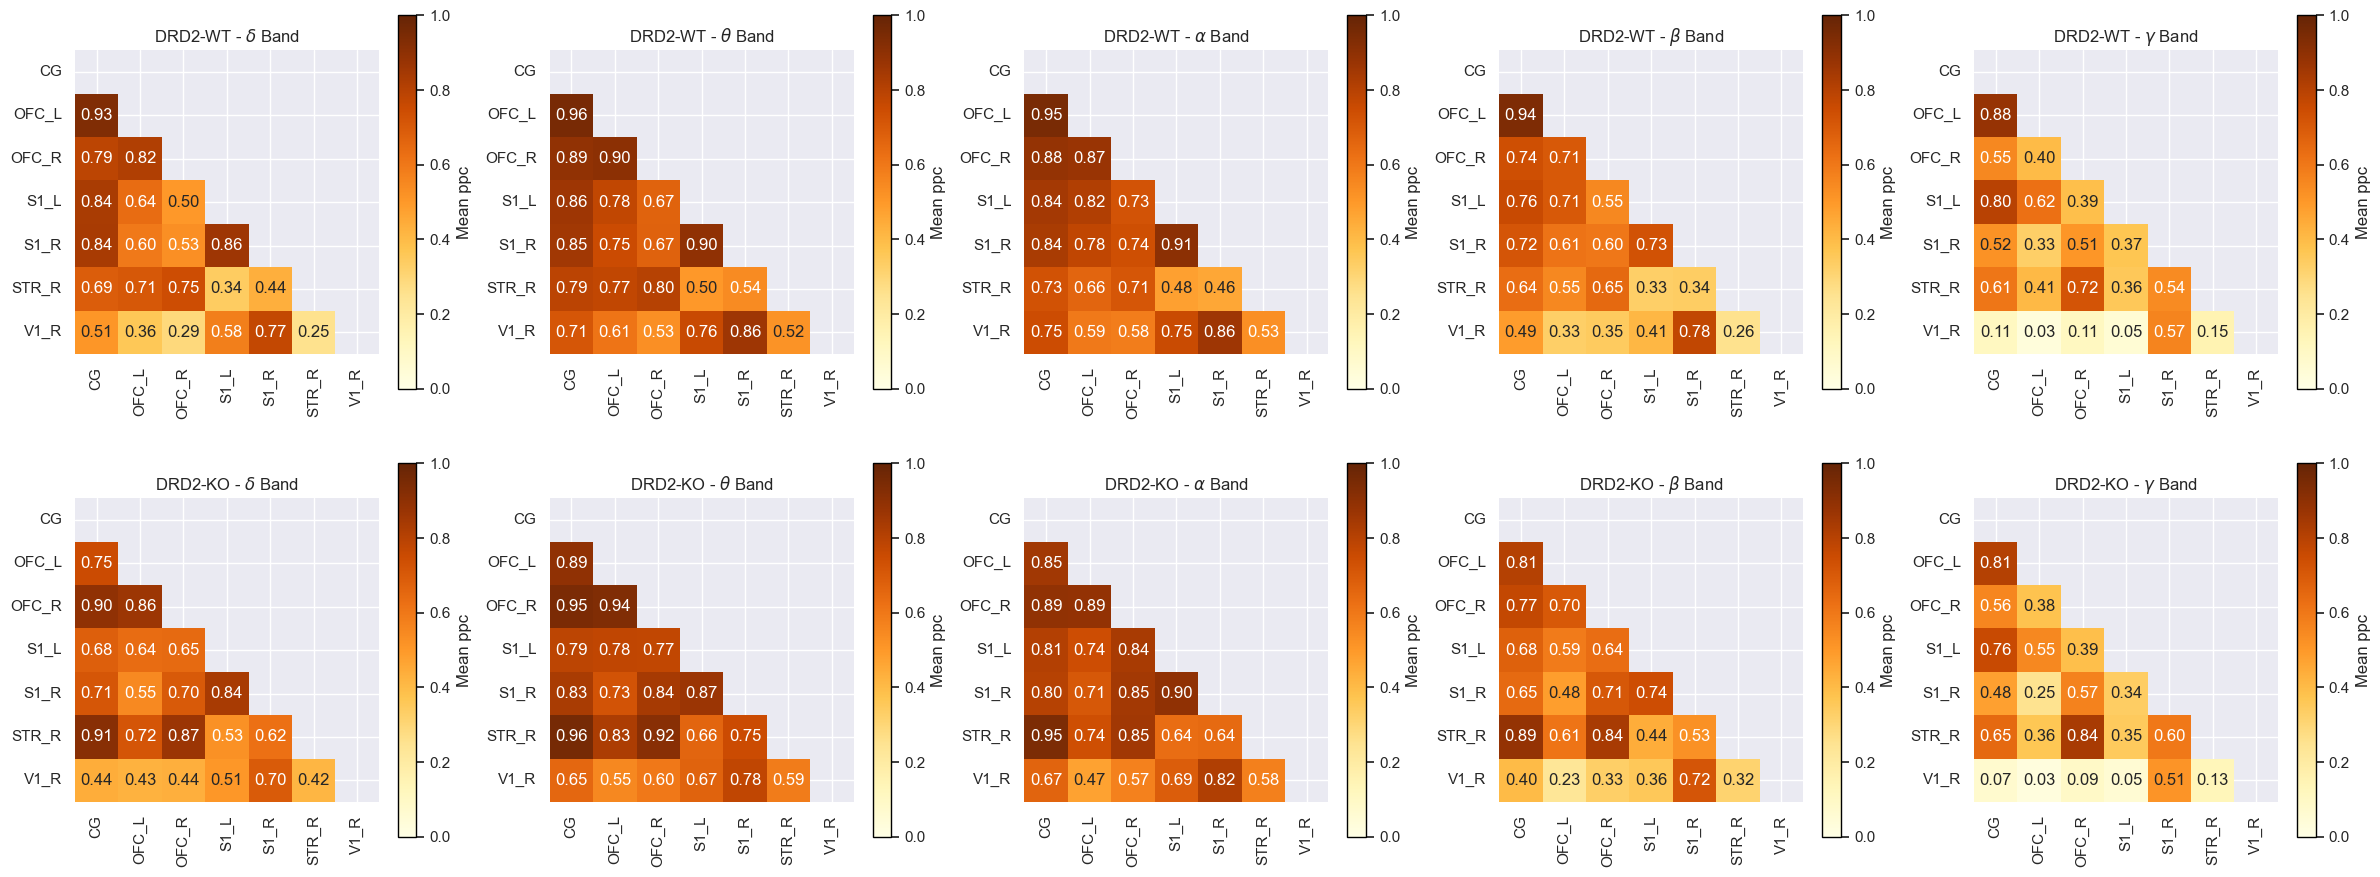

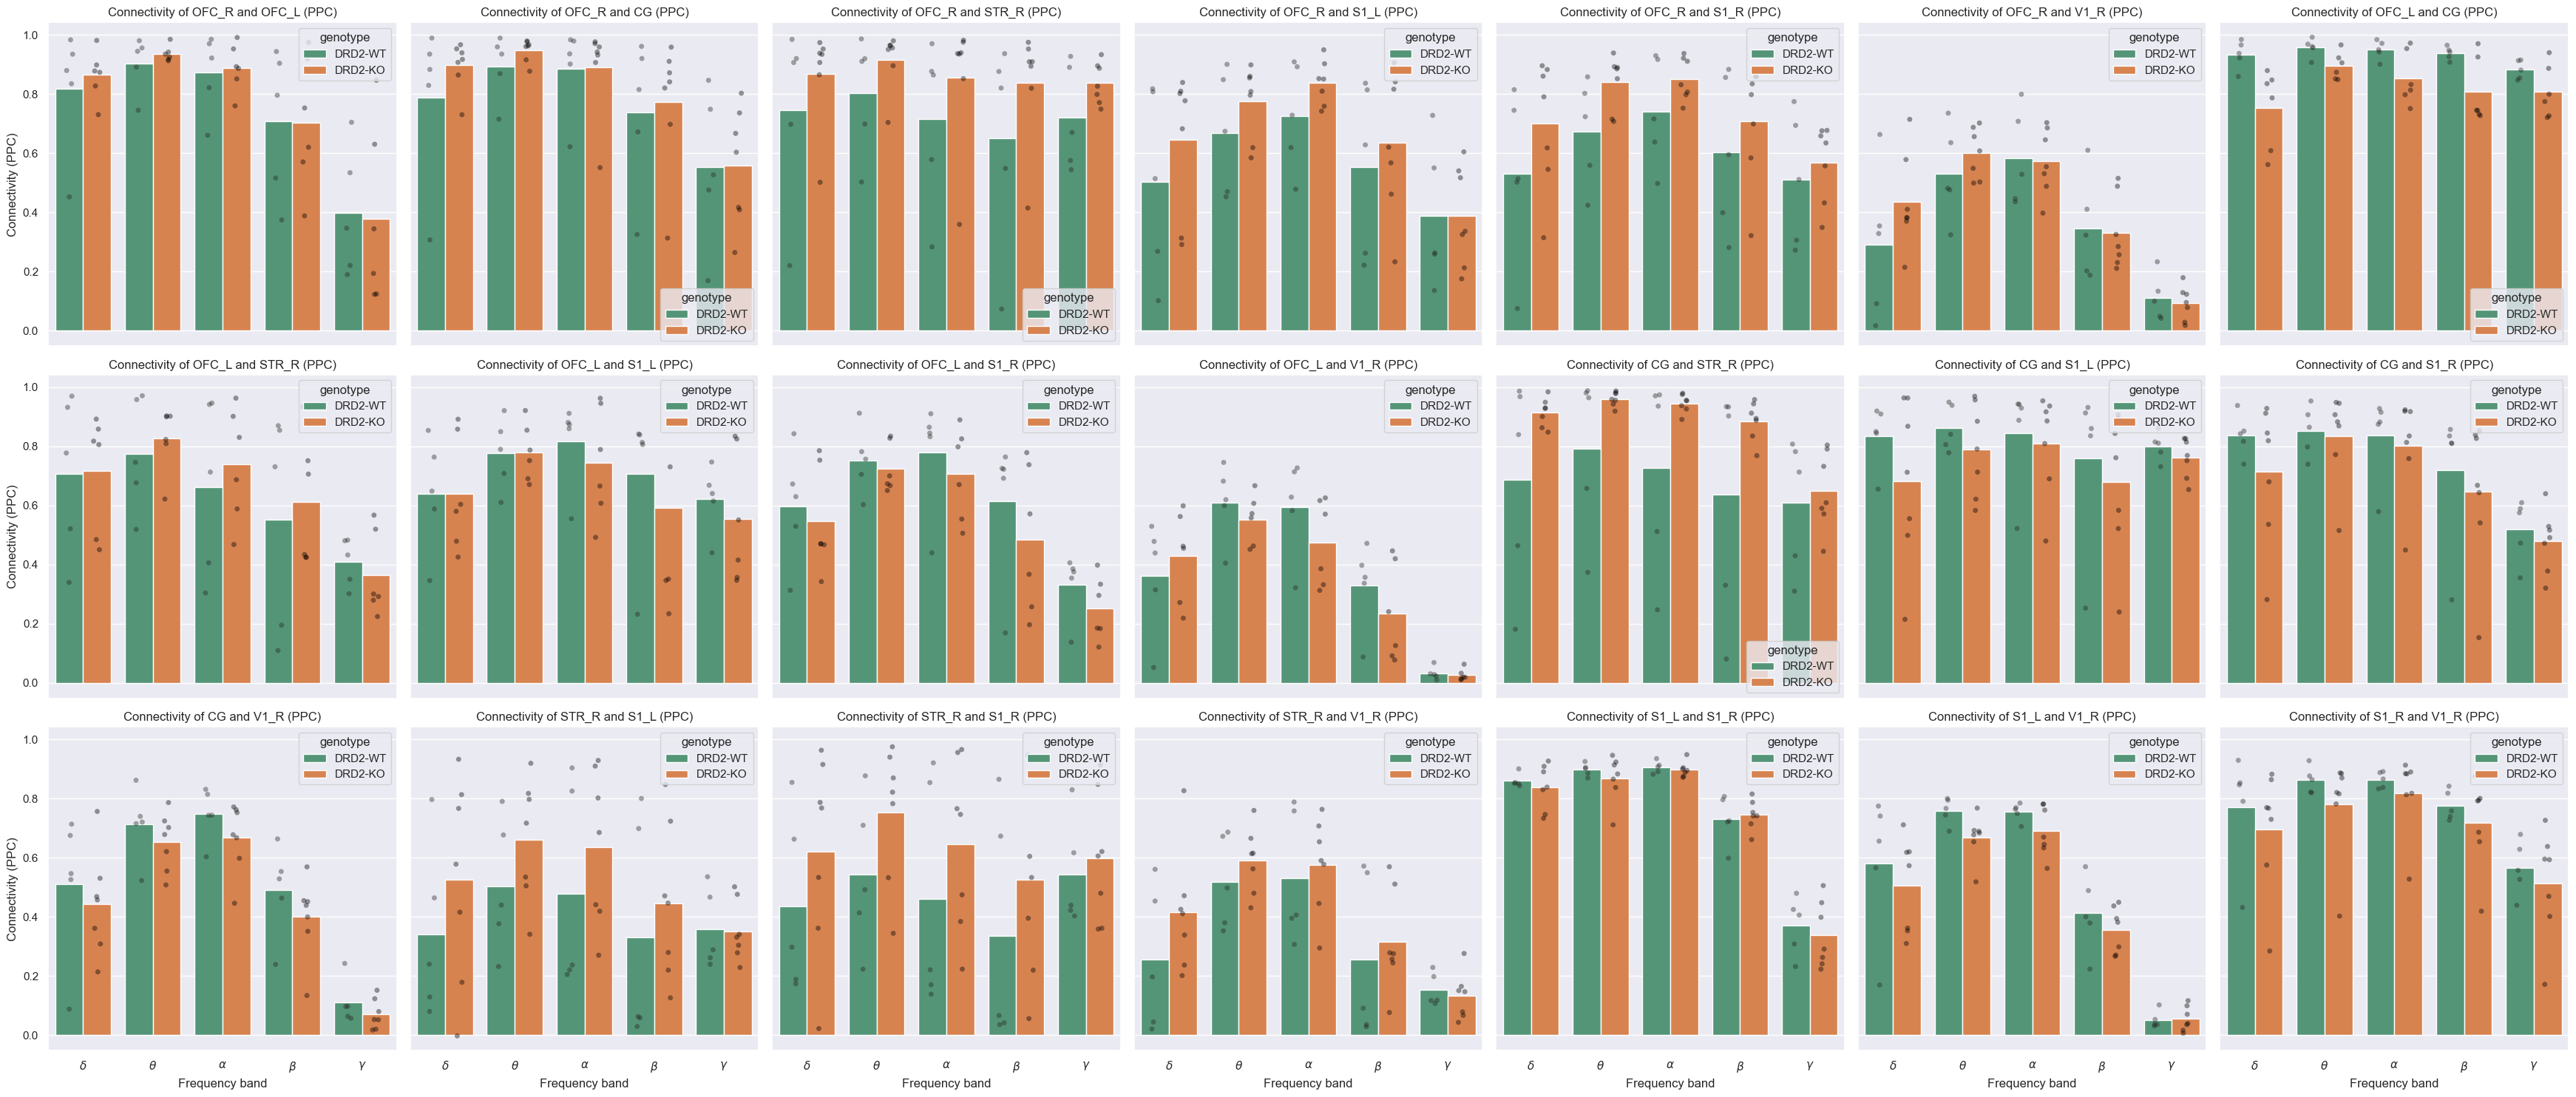

In [120]:
generate_grid_plot_wt_vs_ko(ppc)
generate_barplots(ppc)

### Granger Causality between brain-regions; WT vs. KO comparison

First, let's define two functions that allow us to compute the time-reversed Granger Causality between two electrodes.

In [5]:
def compute_indices(subject_epochs, channel_a, channel_b):
    signals_a = [
        idx
        for idx, ch_info in enumerate(subject_epochs.info["chs"])
        if ch_info["ch_name"] == channel_a
    ]
    # occipital sensors
    signals_b = [
        idx
        for idx, ch_info in enumerate(subject_epochs.info["chs"])
        if ch_info["ch_name"] == channel_b
    ]
    
    indices_ab = (np.array([signals_a]), np.array([signals_b]))  # A => B
    indices_ba = (np.array([signals_b]), np.array([signals_a]))  # B => A
    
    return indices_ab, indices_ba

In [8]:
def get_tr_gc(all_subject_epochs, passed_subject_ids, channel_a, channel_b):
    wt_trgcs, ko_trgcs = [], []
    
    for subject_epochs in all_subject_epochs:
        subject_id = subject_epochs.metadata['animal_id'].iloc[0]
        genotype = subject_epochs.metadata['genotype'].iloc[0]
        
        # check if we want to compute for this subject/animal
        if subject_id not in passed_subject_ids:
            print(f'Subject {subject_id} was not picked, skipping..')
            continue
        if int(subject_id) in omitted_after_clustering or int(subject_id) in omitted_other:
            print(f'Skipping {subject_id}..')
            continue
            
        indices_ab, indices_ba = compute_indices(subject_epochs, channel_a, channel_b)
            
        annotations = cluster_annotations[int(subject_id)]
        resting_epochs = subject_epochs[subject_epochs.metadata["cluster"] == annotations['rest']]
        resting_epochs = resting_epochs.drop_channels(excluded_chans)
        
        gc_ab = spectral_connectivity_epochs(
            resting_epochs,
            method=["gc"],
            indices=indices_ab,
            fmin=1.01,
            fmax=100,
            gc_n_lags=20,
            verbose='WARNING'
        )  # A => B
        gc_ba = spectral_connectivity_epochs(
            resting_epochs,
            method=["gc"],
            indices=indices_ba,
            fmin=1.01,
            fmax=100,
            gc_n_lags=20,
            verbose='WARNING'
        )  # B => A
        freqs = gc_ab.freqs
        net_gc = gc_ab.get_data() - gc_ba.get_data()  # [A => B] - [B => A]
        # compute GC on time-reversed signals
        gc_tr_ab = spectral_connectivity_epochs(
            resting_epochs,
            method=["gc_tr"],
            indices=indices_ab,
            fmin=1.01,
            fmax=100,
            gc_n_lags=20,
            verbose='WARNING'
        )  # TR[A => B]
        gc_tr_ba = spectral_connectivity_epochs(
            resting_epochs,
            method=["gc_tr"],
            indices=indices_ba,
            fmin=1.01,
            fmax=100,
            gc_n_lags=20,
            verbose='WARNING'
        )  # TR[B => A]
        
        # compute net GC on time-reversed signals (TR[A => B] - TR[B => A])
        net_gc_tr = gc_tr_ab.get_data() - gc_tr_ba.get_data()
        
        # compute TRGC
        trgc = net_gc - net_gc_tr
        
        wt_trgcs.append(trgc) if genotype == "DRD2-WT" else ko_trgcs.append(trgc)
        
    return freqs, wt_trgcs, ko_trgcs

Let's compute the data for the channels OFC_L and CG for all subjects, and split the data into WT and KO resting-state epoch TR-GC

In [9]:
freqs, wt_trgcs, ko_trgcs = get_tr_gc(all_subject_epochs, passed_subject_ids, "OFC_L", "CG")

To inspect the variation between WT subjects and between KO subjects, let's create a grid plot of the individual TR GC traces

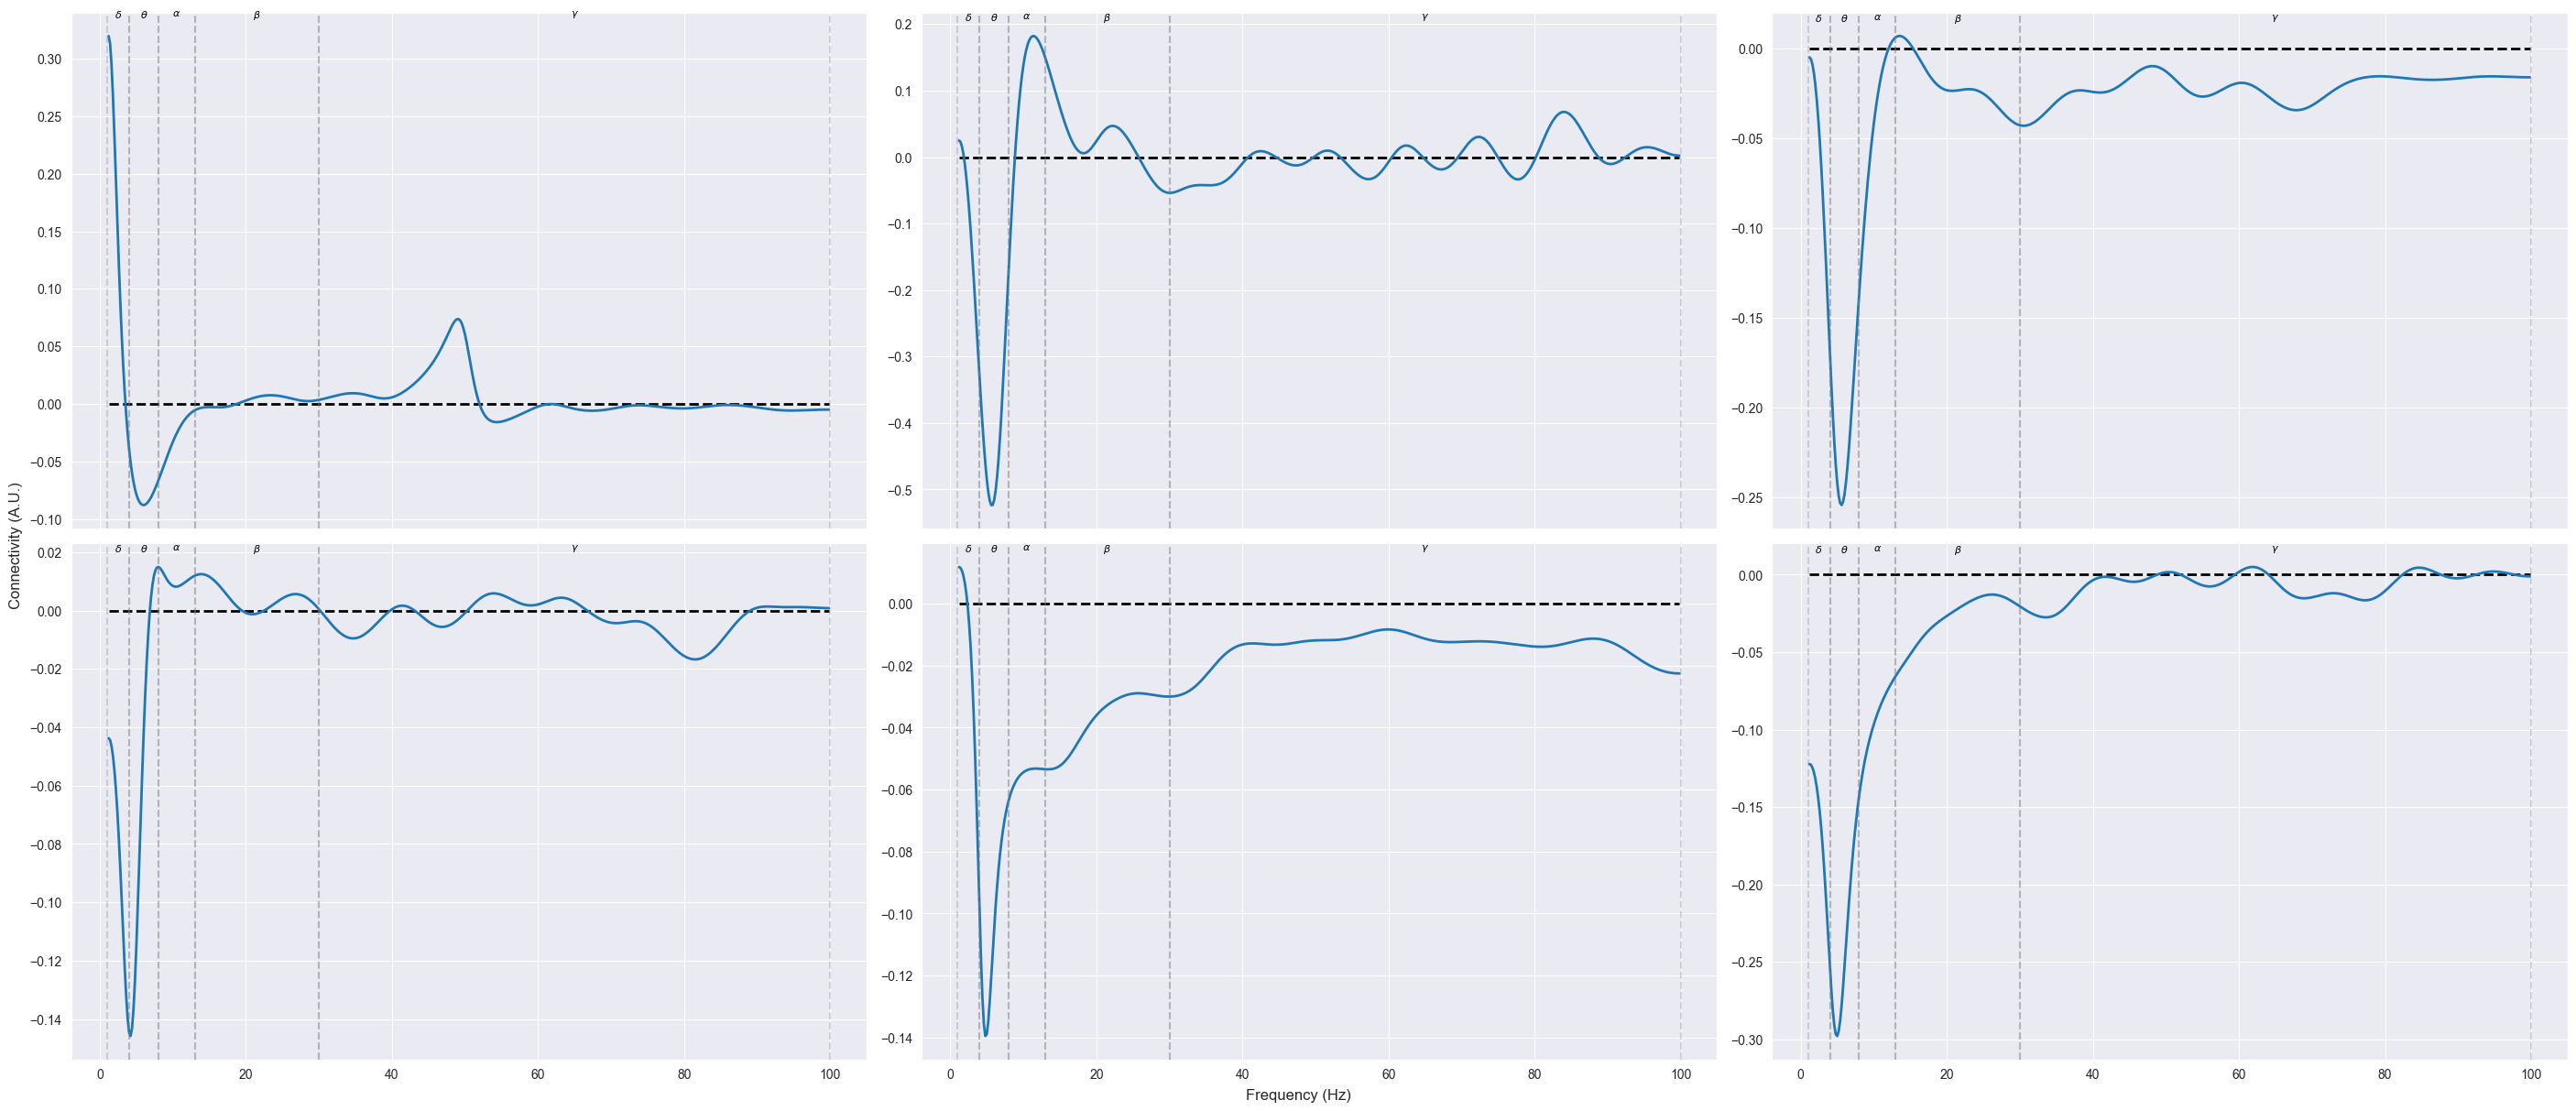

In [54]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(28, 12), sharex=True, sharey=True)
axs = axs.ravel()

for i, gc_trace in enumerate(wt_trgcs):
    axs[i].plot((freqs[0], freqs[-1]), (0, 0), linewidth=2, linestyle="--", color="k")
    axs[i].plot(freqs, gc_trace[0], linewidth=2)
    for band, (start, end) in freq_bands_eeg.items():
        axs[i].axvline(x=start, color='gray', linestyle='--', alpha=0.3)
        axs[i].axvline(x=end, color='gray', linestyle='--', alpha=0.3)
        axs[i].text((start + end) / 2, axs[i].get_ylim()[1] * 1.01, band, horizontalalignment='center', verticalalignment='top', fontsize=8, color='black')

fig.text(0.5, 0, 'Frequency (Hz)', ha='center', va='center', fontsize=12)
fig.text(0, 0.5, 'Connectivity (A.U.)', ha='center', va='center', rotation='vertical', fontsize=12)
plt.tight_layout()
plt.show()

Now we do the same for the KO subjects

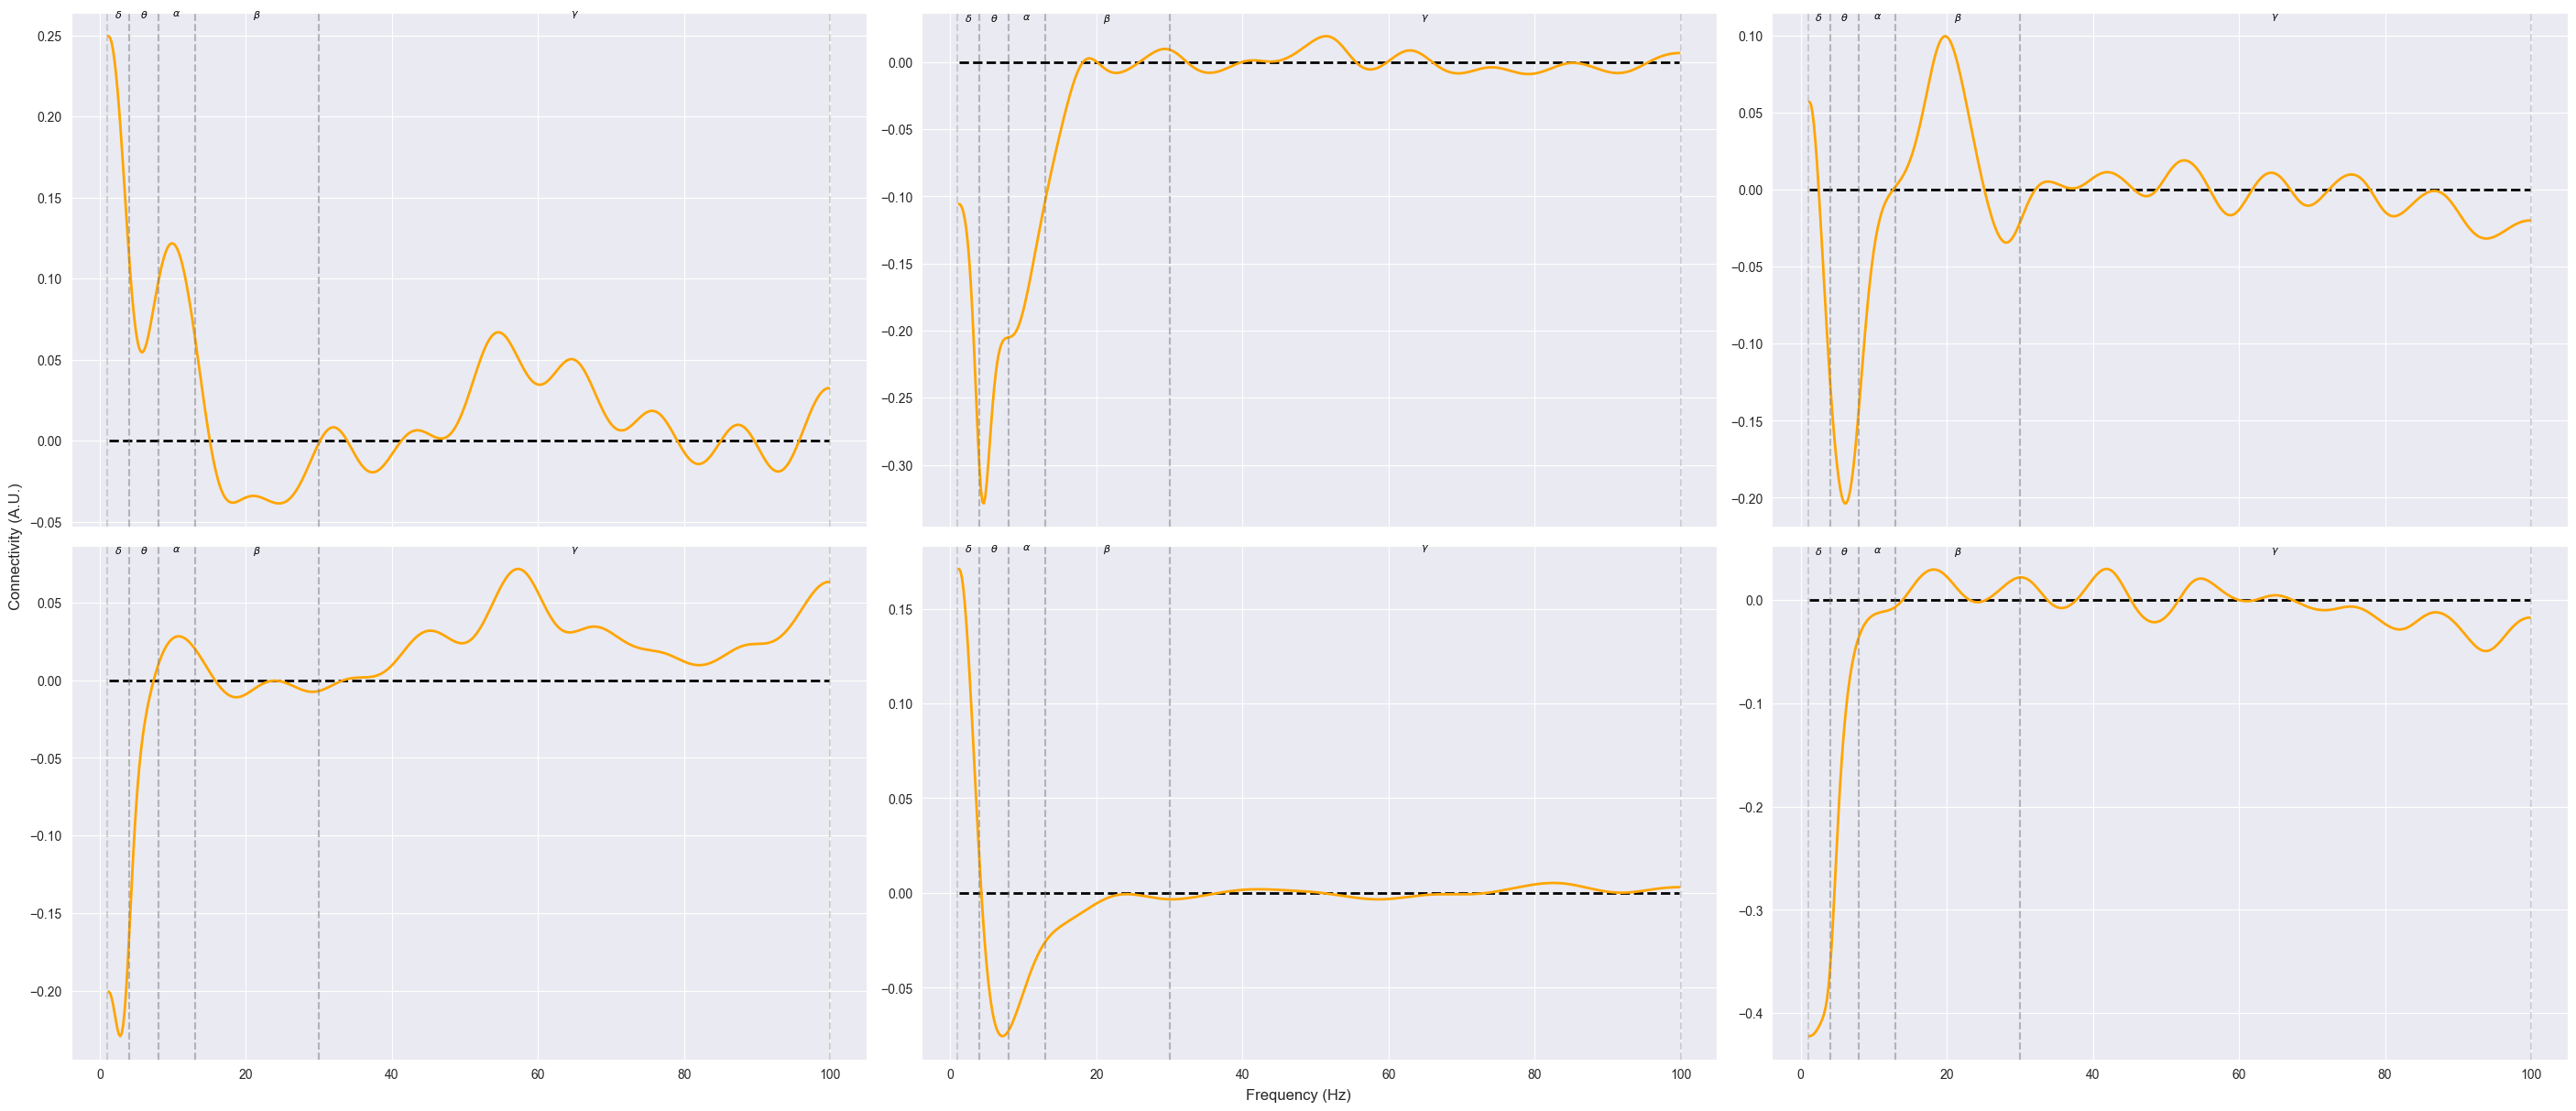

In [58]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(28, 12), sharex=True, sharey=True)
axs = axs.ravel()

for i, gc_trace in enumerate(ko_trgcs):
    axs[i].plot((freqs[0], freqs[-1]), (0, 0), linewidth=2, linestyle="--", color="k")
    axs[i].plot(freqs, gc_trace[0], linewidth=2, color='orange')
    for band, (start, end) in freq_bands_eeg.items():
        axs[i].axvline(x=start, color='gray', linestyle='--', alpha=0.3)
        axs[i].axvline(x=end, color='gray', linestyle='--', alpha=0.3)
        axs[i].text((start + end) / 2, axs[i].get_ylim()[1] * 1.01, band, horizontalalignment='center', verticalalignment='top', fontsize=8, color='black')

fig.text(0.5, 0, 'Frequency (Hz)', ha='center', va='center', fontsize=12)
fig.text(0, 0.5, 'Connectivity (A.U.)', ha='center', va='center', rotation='vertical', fontsize=12)
plt.tight_layout()
plt.show()

Let's average the TR-GC measures of all WT subjects, as well as all KO subjects

In [41]:
averaged_wt_trgcs = np.mean(wt_trgcs, axis=0)
averaged_ko_trgcs = np.mean(ko_trgcs, axis=0)

And now we plot the genotype averages

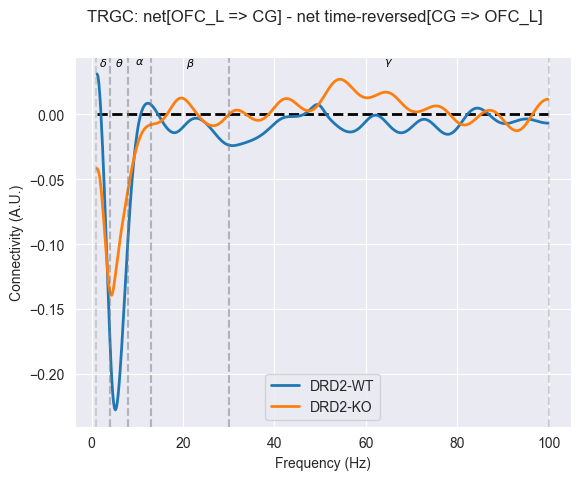

In [40]:
fig, axis = plt.subplots(1, 1)
axis.plot((freqs[0], freqs[-1]), (0, 0), linewidth=2, linestyle="--", color="k")
axis.plot(freqs, averaged_wt_trgcs[0], linewidth=2, label='DRD2-WT')
axis.plot(freqs, averaged_ko_trgcs[0], linewidth=2, label='DRD2-KO')
for band, (start, end) in freq_bands_eeg.items():
    axis.axvline(x=start, color='gray', linestyle='--', alpha=0.3)
    axis.axvline(x=end, color='gray', linestyle='--', alpha=0.3)
    axis.text((start + end) / 2, axis.get_ylim()[1] * 1.01, band, horizontalalignment='center', verticalalignment='top', fontsize=8, color='black')

axis.set_xlabel("Frequency (Hz)")
axis.set_ylabel("Connectivity (A.U.)")
fig.suptitle(f"TRGC: net[OFC_L => CG] - net time-reversed[OFC_L => CG]")
plt.legend()
plt.show()

Now, lets try two other channels

In [59]:
freqs, wt_trgcs, ko_trgcs = get_tr_gc(all_subject_epochs, passed_subject_ids, "OFC_L", "STR_R")

Subject 79593 was not picked, skipping..
Subject 80625 was not picked, skipping..
Subject 39489 was not picked, skipping..
Subject 81193 was not picked, skipping..


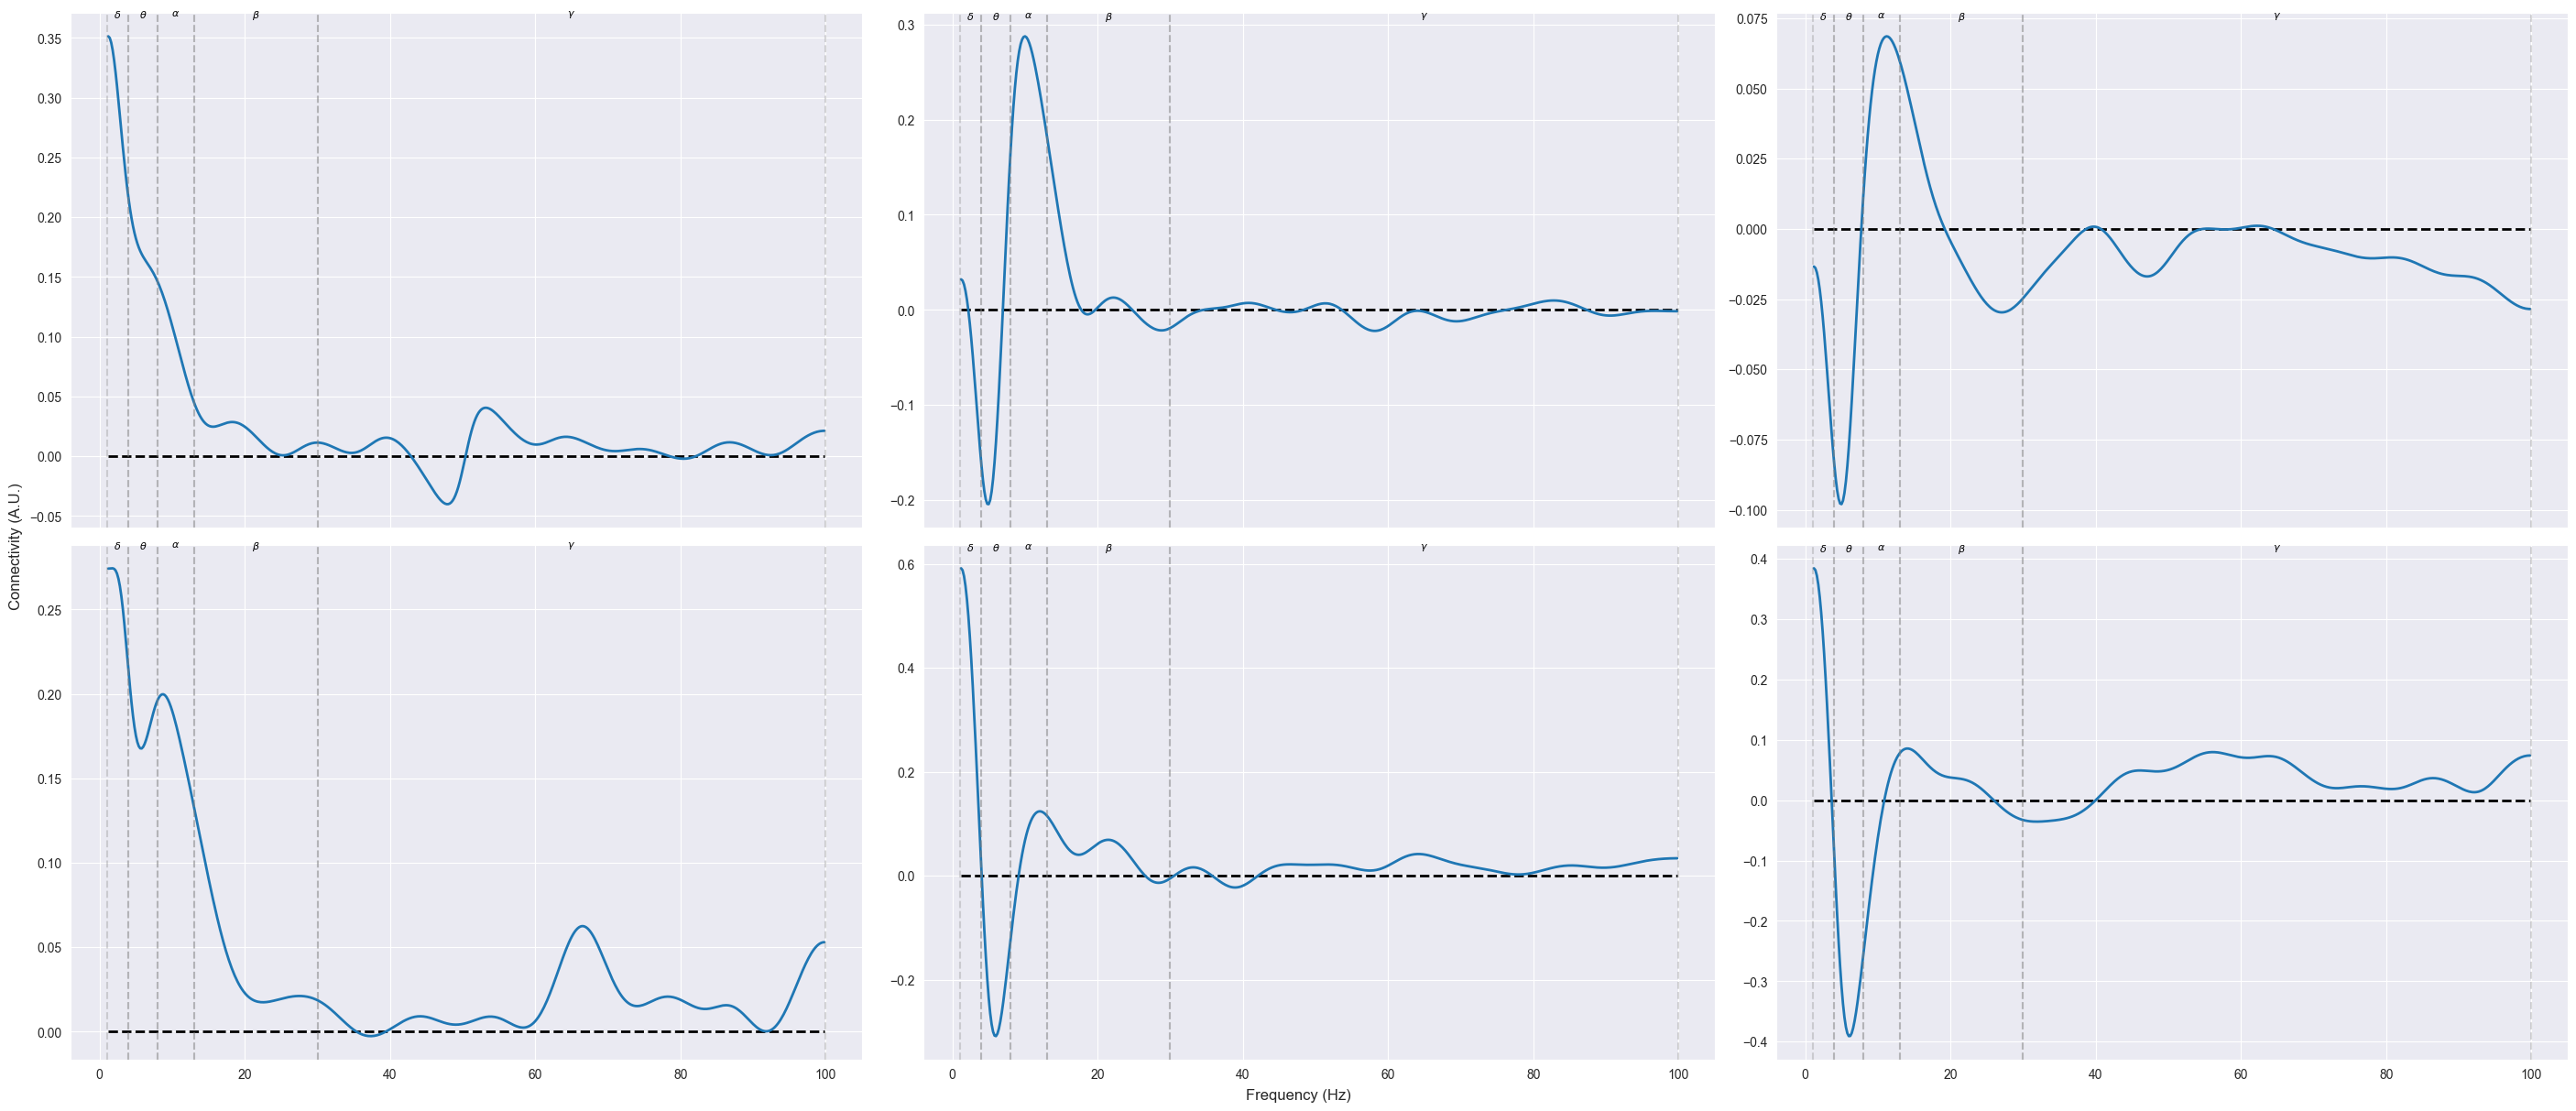

In [60]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(28, 12), sharex=True, sharey=True)
axs = axs.ravel()

for i, gc_trace in enumerate(wt_trgcs):
    axs[i].plot((freqs[0], freqs[-1]), (0, 0), linewidth=2, linestyle="--", color="k")
    axs[i].plot(freqs, gc_trace[0], linewidth=2)
    for band, (start, end) in freq_bands_eeg.items():
        axs[i].axvline(x=start, color='gray', linestyle='--', alpha=0.3)
        axs[i].axvline(x=end, color='gray', linestyle='--', alpha=0.3)
        axs[i].text((start + end) / 2, axs[i].get_ylim()[1] * 1.01, band, horizontalalignment='center', verticalalignment='top', fontsize=8, color='black')

fig.text(0.5, 0, 'Frequency (Hz)', ha='center', va='center', fontsize=12)
fig.text(0, 0.5, 'Connectivity (A.U.)', ha='center', va='center', rotation='vertical', fontsize=12)
plt.tight_layout()
plt.show()

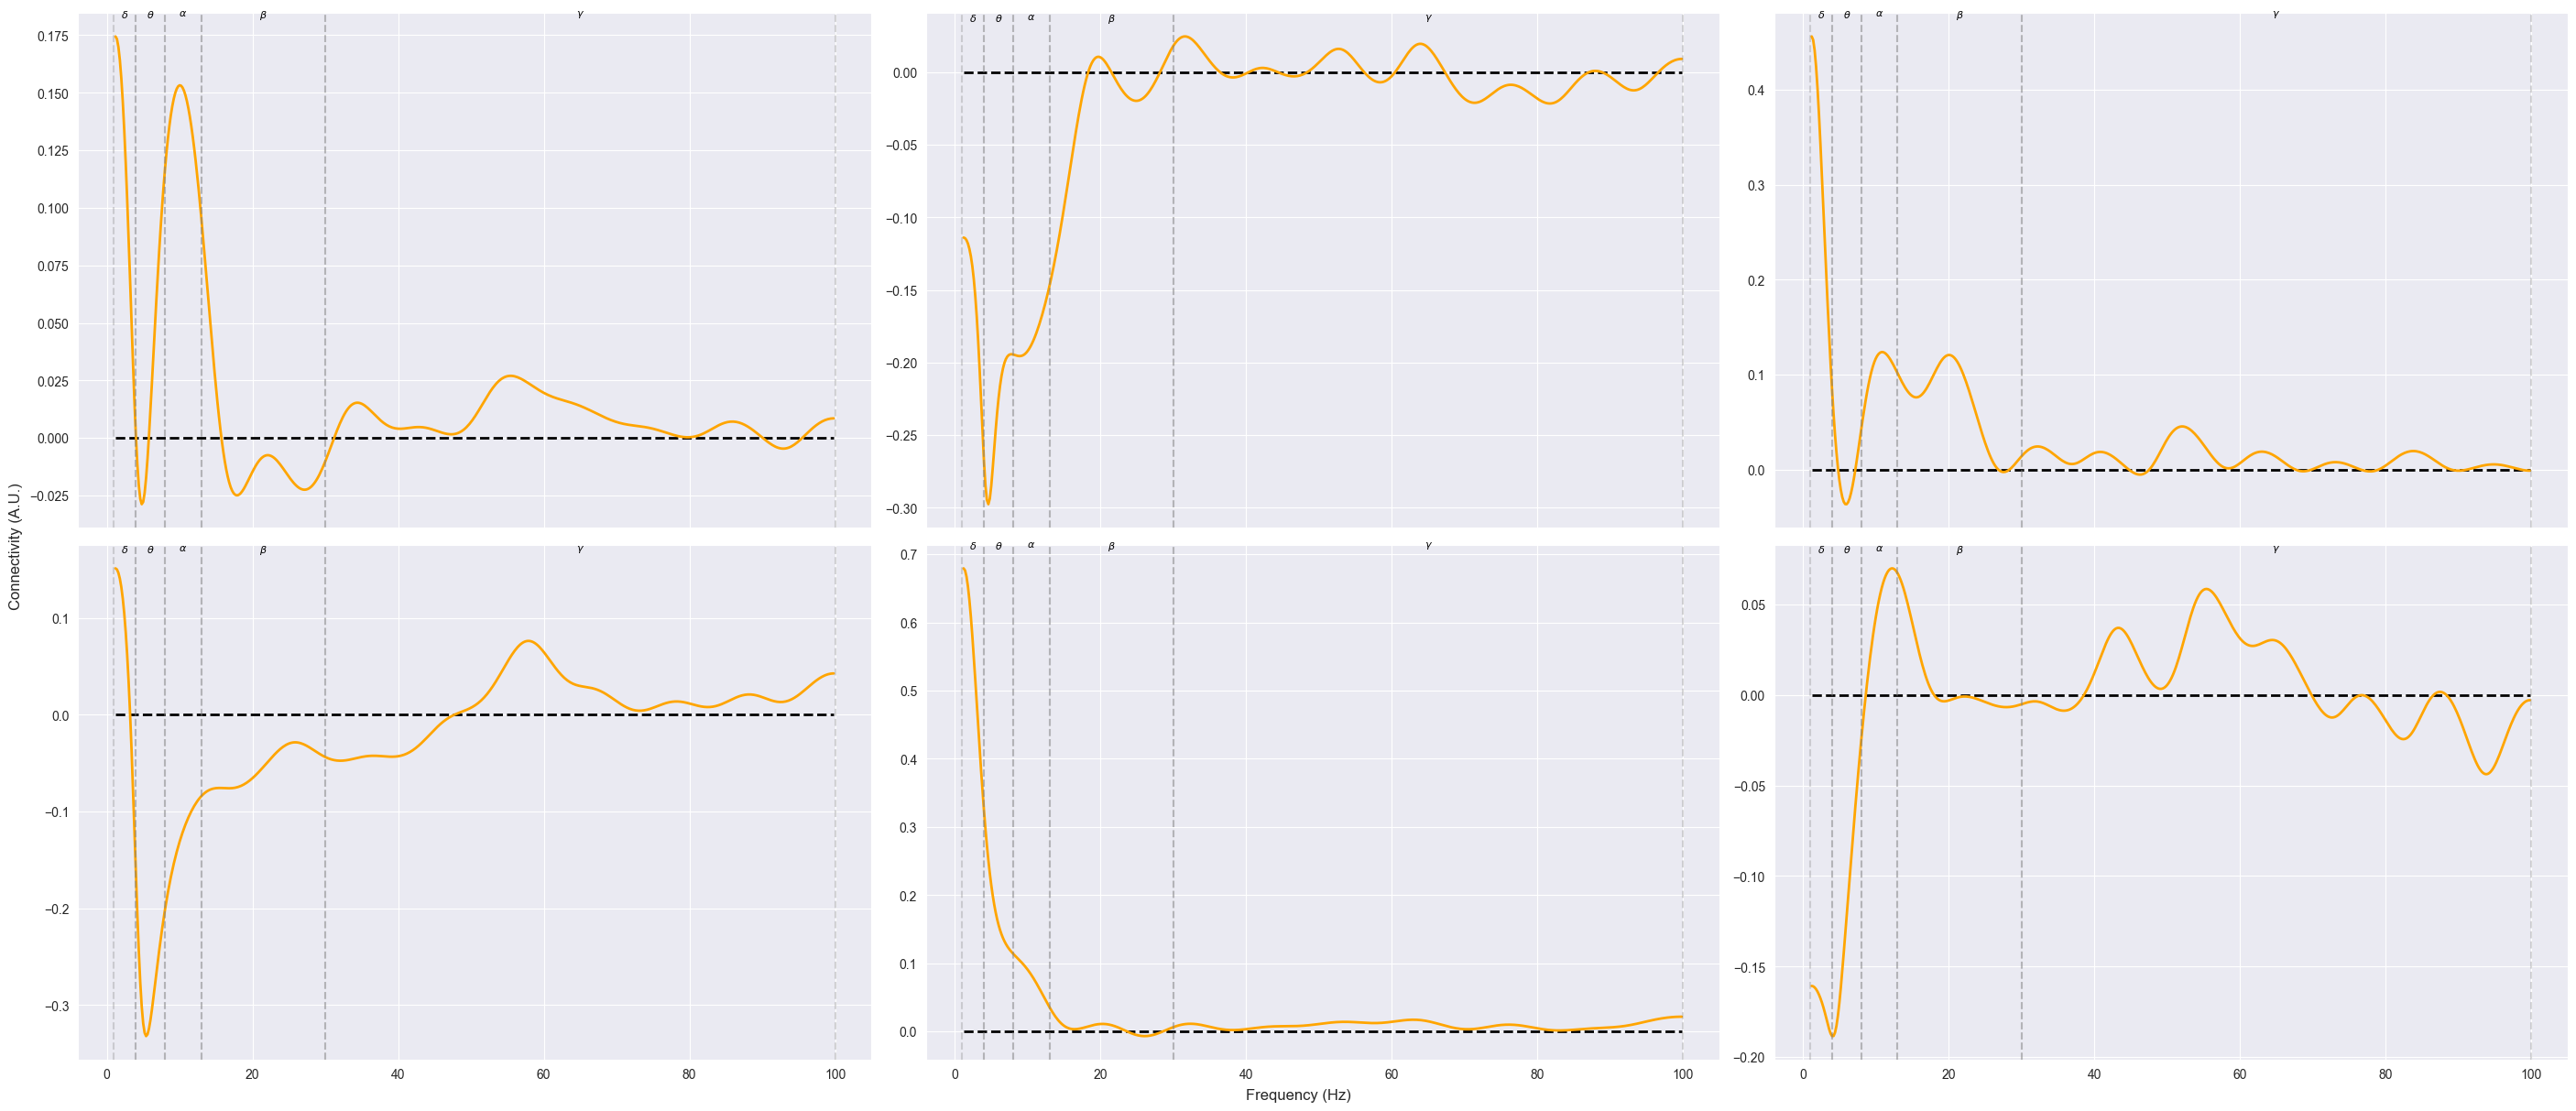

In [61]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(28, 12), sharex=True, sharey=True)
axs = axs.ravel()

for i, gc_trace in enumerate(ko_trgcs):
    axs[i].plot((freqs[0], freqs[-1]), (0, 0), linewidth=2, linestyle="--", color="k")
    axs[i].plot(freqs, gc_trace[0], linewidth=2, color='orange')
    for band, (start, end) in freq_bands_eeg.items():
        axs[i].axvline(x=start, color='gray', linestyle='--', alpha=0.3)
        axs[i].axvline(x=end, color='gray', linestyle='--', alpha=0.3)
        axs[i].text((start + end) / 2, axs[i].get_ylim()[1] * 1.01, band, horizontalalignment='center', verticalalignment='top', fontsize=8, color='black')

fig.text(0.5, 0, 'Frequency (Hz)', ha='center', va='center', fontsize=12)
fig.text(0, 0.5, 'Connectivity (A.U.)', ha='center', va='center', rotation='vertical', fontsize=12)
plt.tight_layout()
plt.show()

In [62]:
averaged_wt_trgcs = np.mean(wt_trgcs, axis=0)
averaged_ko_trgcs = np.mean(ko_trgcs, axis=0)

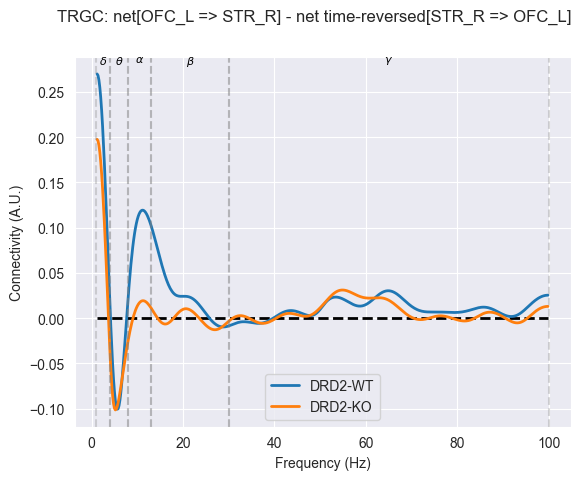

In [64]:
fig, axis = plt.subplots(1, 1)
axis.plot((freqs[0], freqs[-1]), (0, 0), linewidth=2, linestyle="--", color="k")
axis.plot(freqs, averaged_wt_trgcs[0], linewidth=2, label='DRD2-WT')
axis.plot(freqs, averaged_ko_trgcs[0], linewidth=2, label='DRD2-KO')
for band, (start, end) in freq_bands_eeg.items():
    axis.axvline(x=start, color='gray', linestyle='--', alpha=0.3)
    axis.axvline(x=end, color='gray', linestyle='--', alpha=0.3)
    axis.text((start + end) / 2, axis.get_ylim()[1] * 1.01, band, horizontalalignment='center', verticalalignment='top', fontsize=8, color='black')

axis.set_xlabel("Frequency (Hz)")
axis.set_ylabel("Connectivity (A.U.)")
fig.suptitle(f"TRGC: net[OFC_L => STR_R] - net time-reversed[OFC_L => STR_R]")
plt.legend()
plt.show()

In [65]:
freqs, wt_trgcs, ko_trgcs = get_tr_gc(all_subject_epochs, passed_subject_ids, "CG", "STR_R")

Subject 79593 was not picked, skipping..
Subject 80625 was not picked, skipping..
Subject 39489 was not picked, skipping..
Subject 81193 was not picked, skipping..


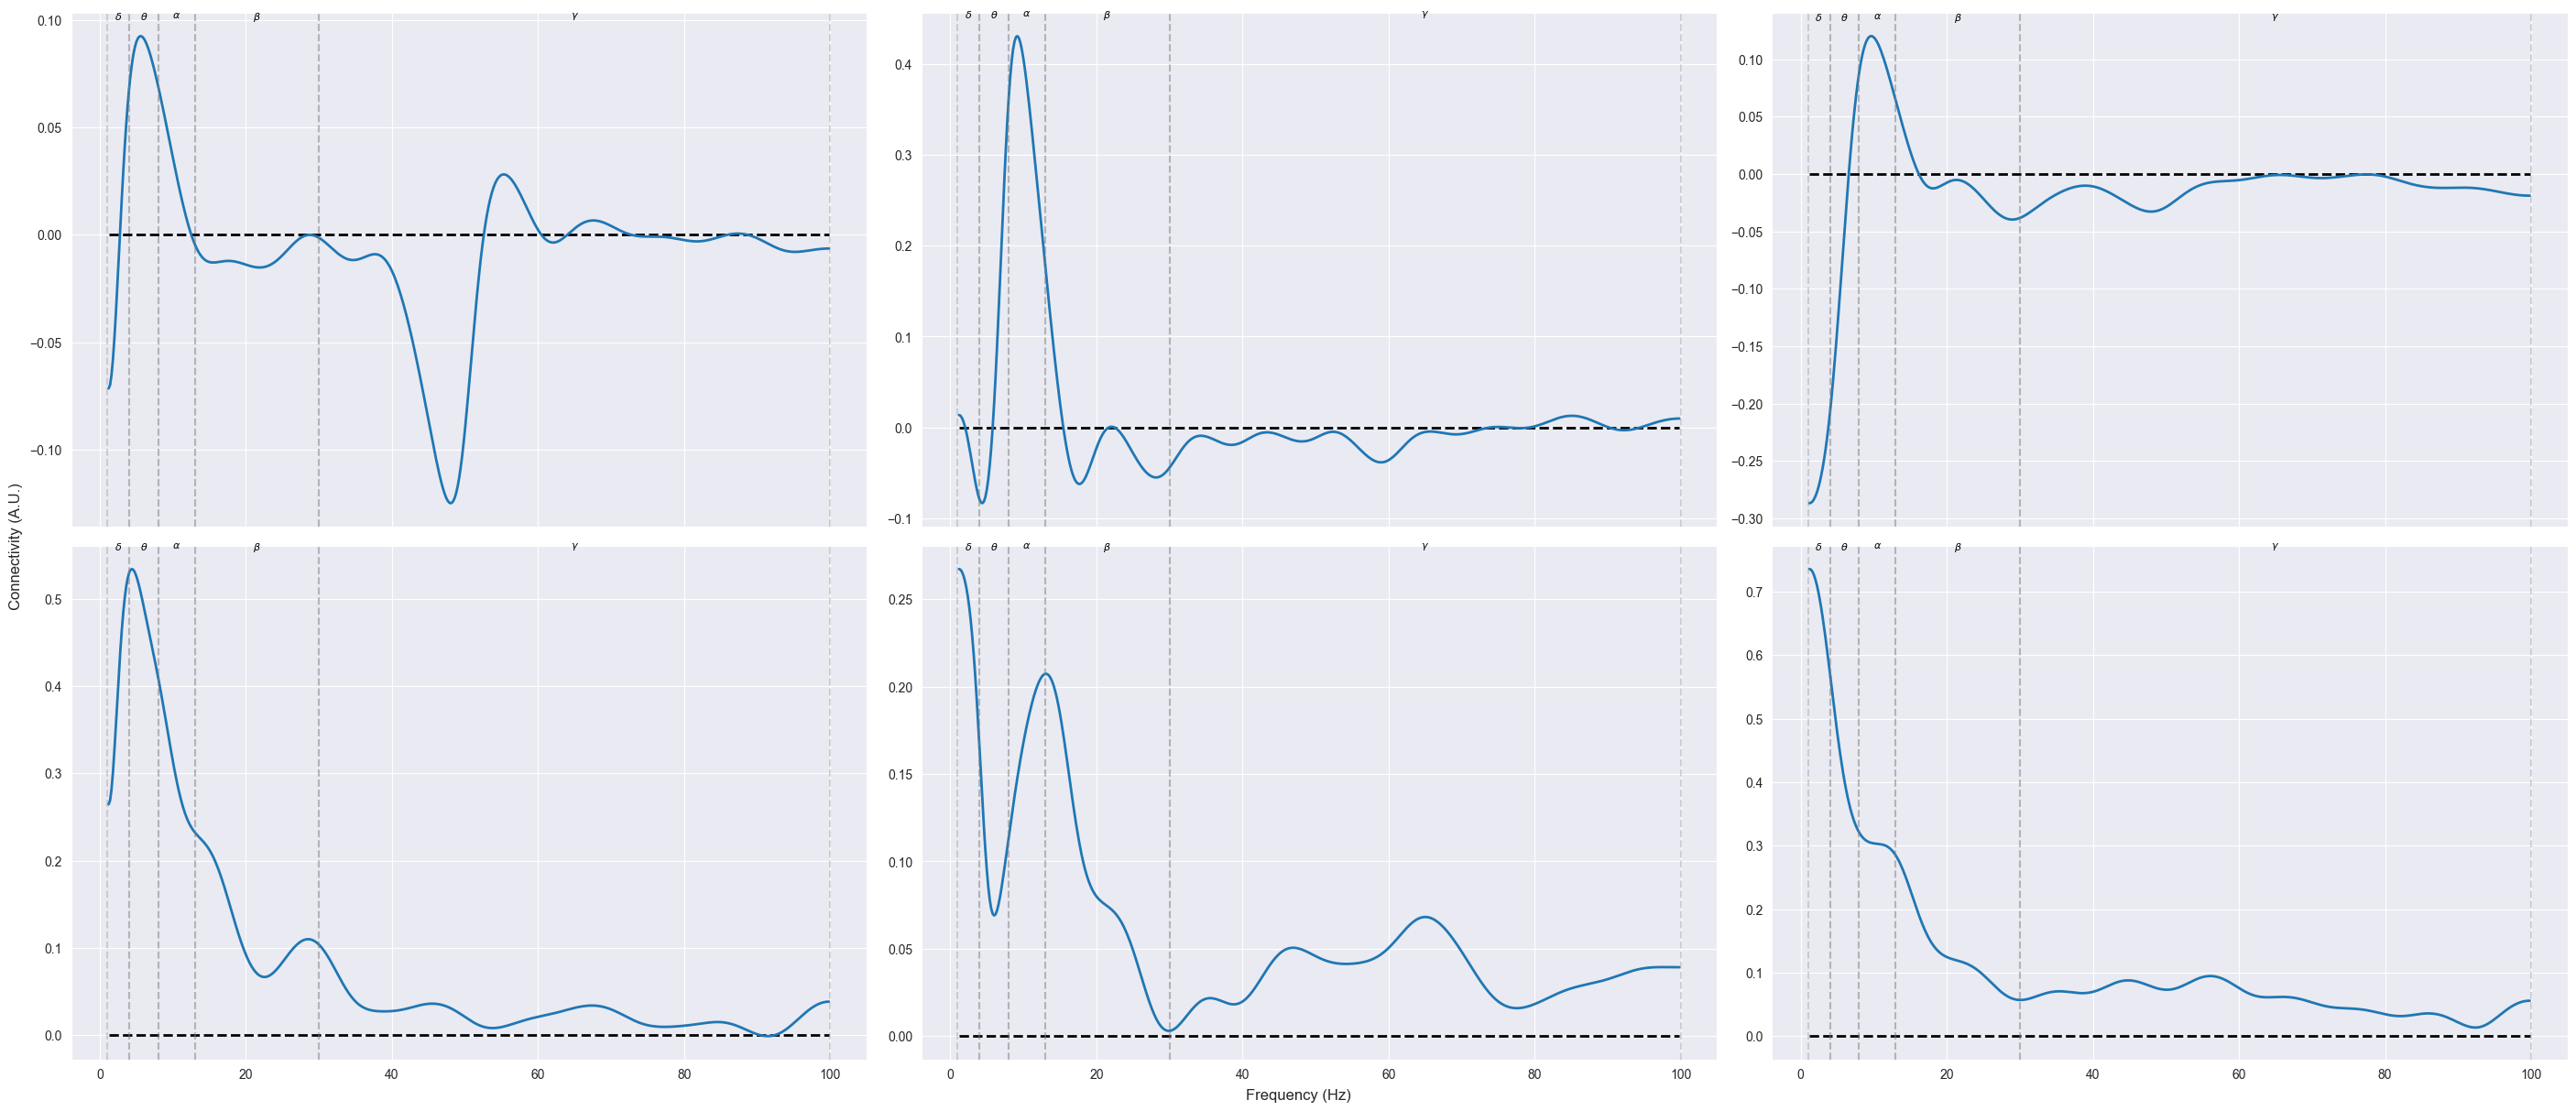

In [66]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(28, 12), sharex=True, sharey=True)
axs = axs.ravel()

for i, gc_trace in enumerate(wt_trgcs):
    axs[i].plot((freqs[0], freqs[-1]), (0, 0), linewidth=2, linestyle="--", color="k")
    axs[i].plot(freqs, gc_trace[0], linewidth=2)
    for band, (start, end) in freq_bands_eeg.items():
        axs[i].axvline(x=start, color='gray', linestyle='--', alpha=0.3)
        axs[i].axvline(x=end, color='gray', linestyle='--', alpha=0.3)
        axs[i].text((start + end) / 2, axs[i].get_ylim()[1] * 1.01, band, horizontalalignment='center', verticalalignment='top', fontsize=8, color='black')

fig.text(0.5, 0, 'Frequency (Hz)', ha='center', va='center', fontsize=12)
fig.text(0, 0.5, 'Connectivity (A.U.)', ha='center', va='center', rotation='vertical', fontsize=12)
plt.tight_layout()
plt.show()

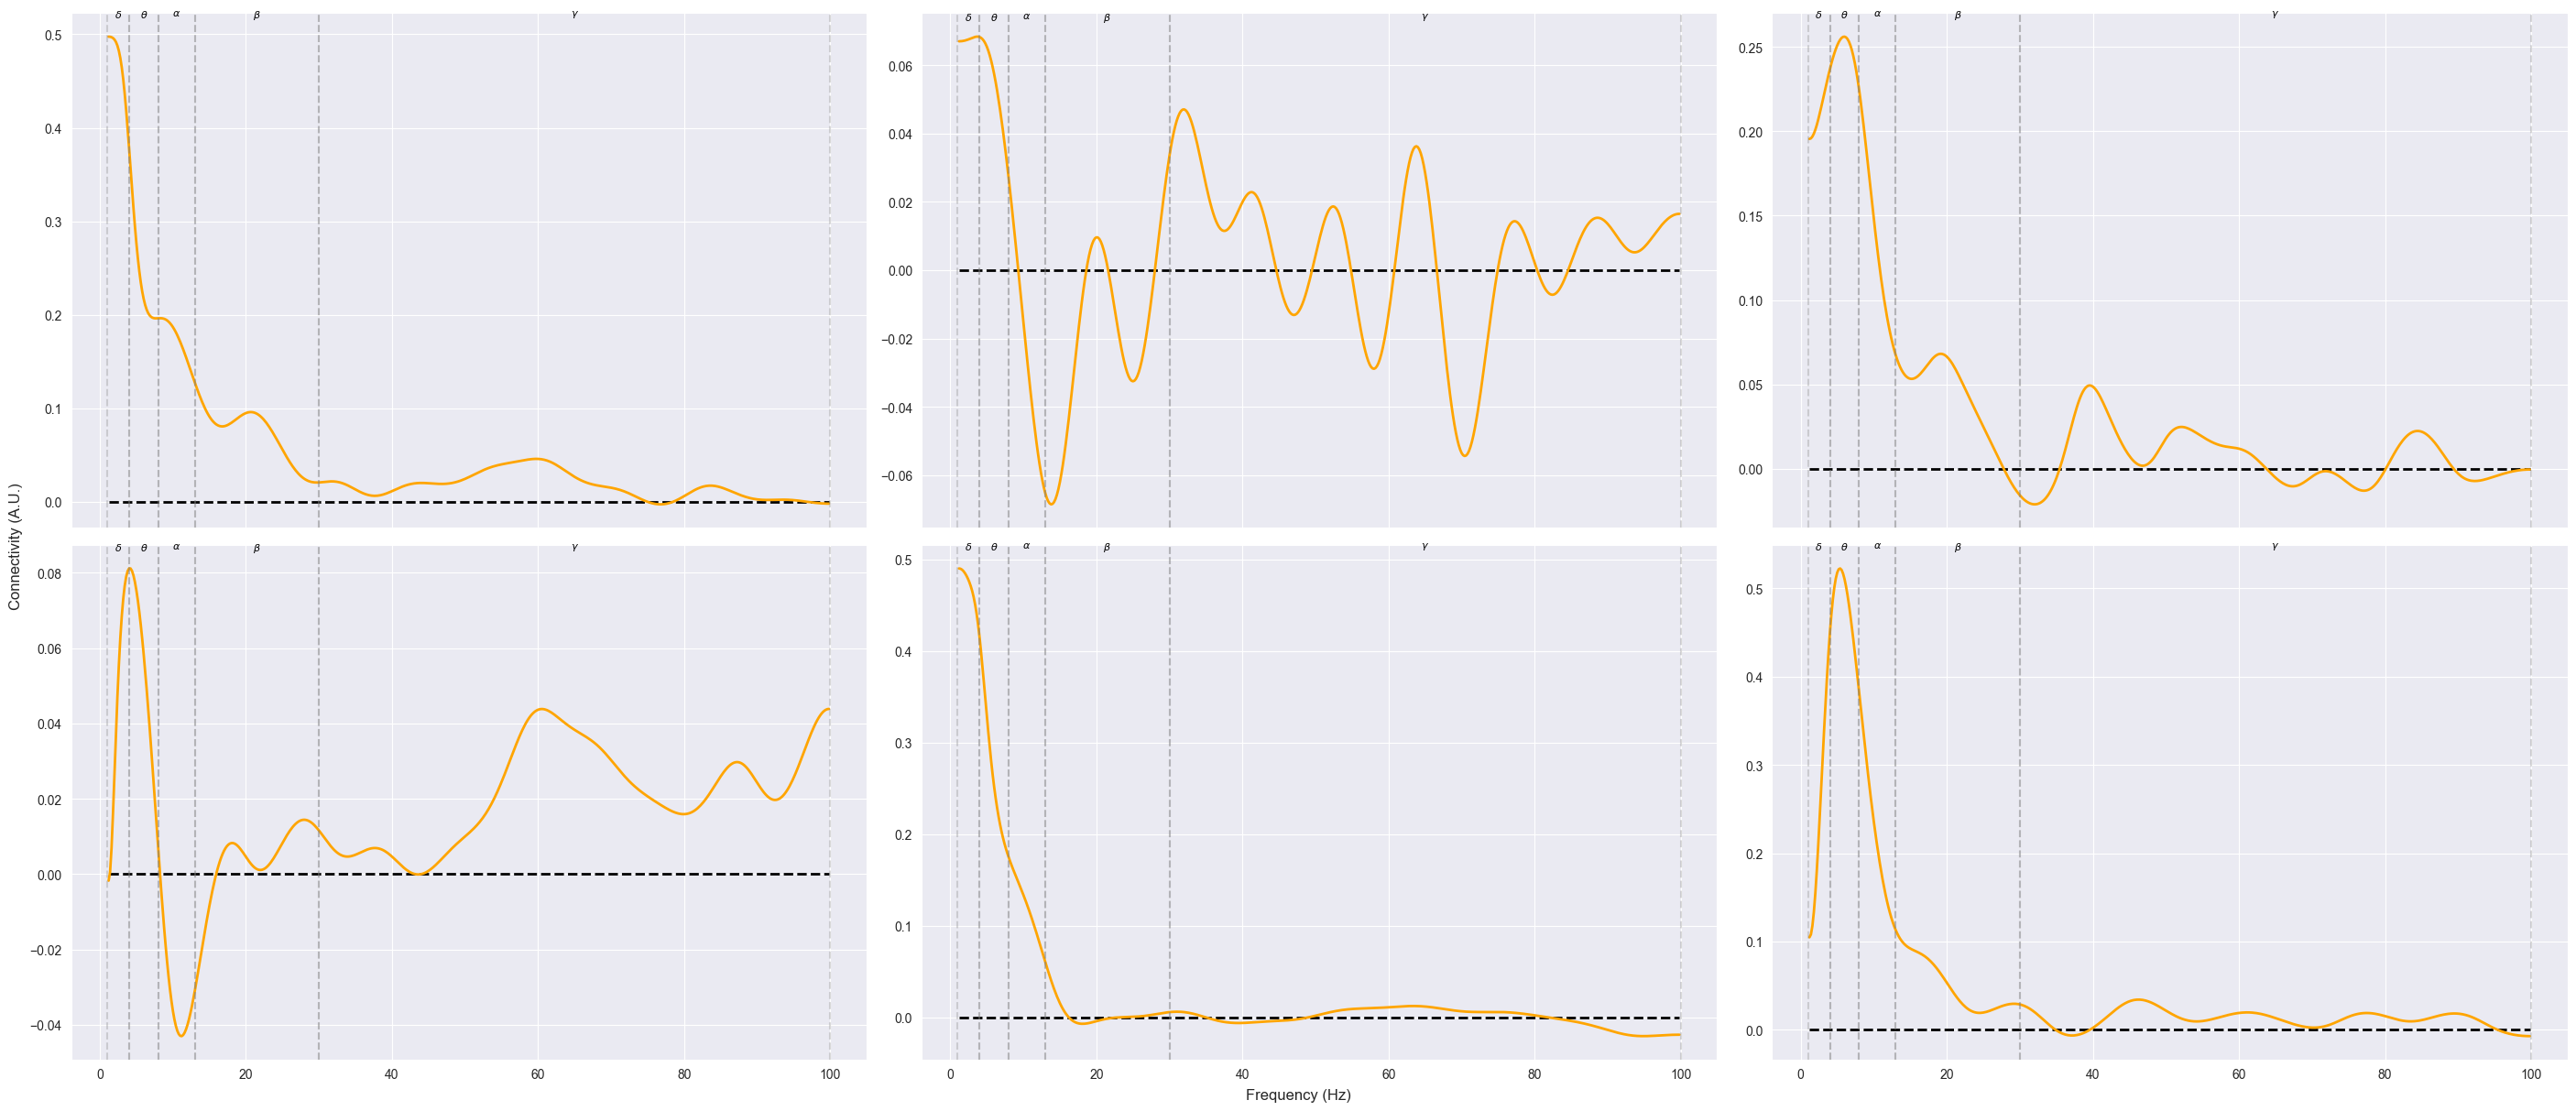

In [67]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(28, 12), sharex=True, sharey=True)
axs = axs.ravel()

for i, gc_trace in enumerate(ko_trgcs):
    axs[i].plot((freqs[0], freqs[-1]), (0, 0), linewidth=2, linestyle="--", color="k")
    axs[i].plot(freqs, gc_trace[0], linewidth=2, color='orange')
    for band, (start, end) in freq_bands_eeg.items():
        axs[i].axvline(x=start, color='gray', linestyle='--', alpha=0.3)
        axs[i].axvline(x=end, color='gray', linestyle='--', alpha=0.3)
        axs[i].text((start + end) / 2, axs[i].get_ylim()[1] * 1.01, band, horizontalalignment='center', verticalalignment='top', fontsize=8, color='black')

fig.text(0.5, 0, 'Frequency (Hz)', ha='center', va='center', fontsize=12)
fig.text(0, 0.5, 'Connectivity (A.U.)', ha='center', va='center', rotation='vertical', fontsize=12)
plt.tight_layout()
plt.show()

In [68]:
averaged_wt_trgcs = np.mean(wt_trgcs, axis=0)
averaged_ko_trgcs = np.mean(ko_trgcs, axis=0)

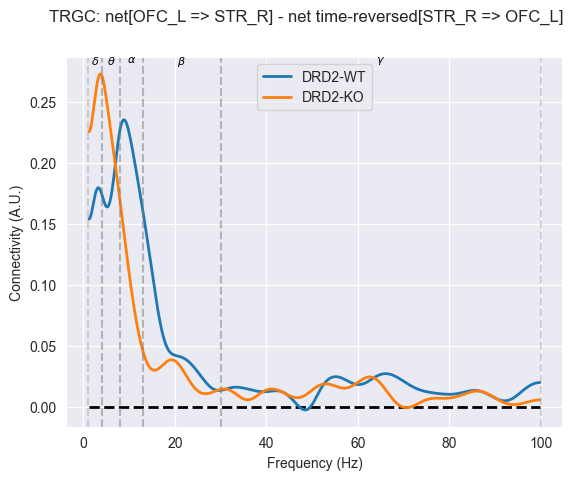

In [69]:
fig, axis = plt.subplots(1, 1)
axis.plot((freqs[0], freqs[-1]), (0, 0), linewidth=2, linestyle="--", color="k")
axis.plot(freqs, averaged_wt_trgcs[0], linewidth=2, label='DRD2-WT')
axis.plot(freqs, averaged_ko_trgcs[0], linewidth=2, label='DRD2-KO')
for band, (start, end) in freq_bands_eeg.items():
    axis.axvline(x=start, color='gray', linestyle='--', alpha=0.3)
    axis.axvline(x=end, color='gray', linestyle='--', alpha=0.3)
    axis.text((start + end) / 2, axis.get_ylim()[1] * 1.01, band, horizontalalignment='center', verticalalignment='top', fontsize=8, color='black')

axis.set_xlabel("Frequency (Hz)")
axis.set_ylabel("Connectivity (A.U.)")
fig.suptitle(f"TRGC: net[OFC_L => STR_R] - net time-reversed[OFC_L => STR_R]")
plt.legend()
plt.show()

#### WT vs KO gridplot of averaged time-reversed Granger Causality

In [10]:
chans = all_subject_epochs[0].info['ch_names']
chans = [chan for chan in chans if chan not in excluded_chans]

fig, axs = plt.subplots(nrows=3, ncols=7, figsize=(35, 15), sharey=True, sharex=True)
axs = axs.ravel()

grid_index = 0
for i in range(len(chans)):
    for j in range(i + 1, len(chans)):
        freqs, wt_trgcs, ko_trgcs = get_tr_gc(all_subject_epochs, passed_subject_ids, chans[i], chans[j])
        
        averaged_wt_trgcs = np.mean(wt_trgcs, axis=0)
        averaged_ko_trgcs = np.mean(ko_trgcs, axis=0)
        
        axs[grid_index].plot((freqs[0], freqs[-1]), (0, 0), linewidth=2, linestyle="--", color="k")
        axs[grid_index].plot(freqs, averaged_wt_trgcs[0], linewidth=2, label='DRD2-WT')
        axs[grid_index].plot(freqs, averaged_ko_trgcs[0], linewidth=2, label='DRD2-KO')
        axs[grid_index].legend()
        for band, (start, end) in freq_bands_eeg.items():
            axs[grid_index].axvline(x=start, color='gray', linestyle='--', alpha=0.3)
            axs[grid_index].axvline(x=end, color='gray', linestyle='--', alpha=0.3)
            axs[grid_index].text((start + end) / 2, axs[grid_index].get_ylim()[1] * 1.01, band, horizontalalignment='center', verticalalignment='top', fontsize=8, color='black')
        axs[grid_index].set_title(f'Time-reversed GC: net[{chans[i]} => {chans[j]}]')
        grid_index += 1

save_figure(os.path.join(plot_folder, f"connectivity/TRGC_wt_vs_ko_grid.pdf"))